In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18
from scipy import interpolate

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## DMParam

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1e8,
    lifetime = 1e25,
)

tf_version = 'zf01'

In [2]:
dm_params = DMParams(
    mode = 'decay',
    primary = 'phot_delta',
    m_DM = 1.2e10,
    lifetime = 1e50,
)

tf_version = 'zf01'

## DarkHistory

In [3]:
from darkhistory.config import load_data
load_data('dep_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}')
load_data('ics_tf', prefix=f'/n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_{tf_version}');

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1_zf01
    for propagating photons...  

 Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


In [4]:
run_name = 'dhc_test'

soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=4.+1, coarsen_factor=12, verbose=1,
    # use fake reionization to get case-A recomb. coeff.
    reion_switch=True, reion_rs=47.,
    photoion_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    photoheat_rate_func=[lambda x: 0., lambda x: 0., lambda x: 0.],
    cross_check_21cmfast=True,
    cross_check_21cmfast_tf_version=tf_version,
    debug_no_bath=False,
)

pickle.dump(soln, open(f"run_info/{run_name}_dh_soln.p", 'wb'))

Loading time: 0.015 s


  0%|          | 0/534 [00:00<?, ?it/s]WARNING:root:Cross checking 21cmfast!


Initialization time: 0.064 s


 64%|██████▍   | 344/534 [00:53<00:29,  6.52it/s]WARNING:root:Setting coarsen_factor=1!
573it [01:05,  8.76it/s]                         


Main loop time: 65.417 s


In [5]:
run_name = 'dhc_test'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
dh_xe_interp_func = lambda z: interpolate.interp1d(dh_soln['rs']-1, dh_soln['x'][:, 0])(z).item()
hep_N_arr = np.array([s.N for s in dh_soln['highengphot']])
hep_rs_arr = np.array([s.rs for s in dh_soln['highengphot']])
dh_bath_N_interp_func = interpolate.interp1d(hep_rs_arr-1, hep_N_arr, axis=0)

In [6]:
! mkdir $P21C_CACHE_DIR/dhc_test
! cp -v run_info/dhc_test_dh_soln.p $P21C_CACHE_DIR/dhc_test/dh_init_soln.p

mkdir: cannot create directory ‘/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test’: File exists


'run_info/dhc_test_dh_soln.p' -> '/n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test/dh_init_soln.p'


In [12]:
return_dict = evolve(
    run_name = 'dhc_test',
    z_start = 45.,
    z_end = 5.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = tf_version,
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 16,
            BOX_LEN = 16 * 4, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            #SIGMA_8 = Planck18.meta['sigma8'],
            SIGMA_8 = 1e-8,
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = False,
    debug_flags = [],
    debug_xray_multiplier = 1.,
    debug_astro_params = p21c.AstroParams(
        L_X = 0. # log10 value
    ),
    save_dir='run_info',
    custom_YHe = 0.245,
    #debug_dhc_delta_fixed=True,
    #debug_dhc_DH_xe_func=dh_xe_interp_func,
    #dh_bath_N_interp_func=dh_bath_N_interp_func,
    track_Tk_xe=True,
    track_Tk_xe_set_tf_input=False,
)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1585+ge3818c7.d20231008
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/dhc_test
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial conditions.


get_init_cond 72.41126376049257 0.0009554013694457287


i_z=0/203 z=44.68


This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.467847e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.467847e+01 E_tot_ave = 0.000000e+00
before 72.41126 0.0009554012
input_heating 0.36777797
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.422620e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.422620e+01 E_tot_ave = 0.000000e+00
after 71.468216 0.00095685205
DM21CM DEBUG: xray_tot_eng=6.207e-05 eV/Bavg
DM21CM DEBUG: xra

i_z=1/203 z=44.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 71.468216 0.00095685205
input_heating 0.36910868
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.377842e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.377842e+01 E_tot_ave = 0.000000e+00
after 70.54149 0.0009583403
DM21CM DEBUG: xray_tot_eng=6.164e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 44.22620305254949
[4.41619662e-07 6.85180292e-09 3.77271692e-07 2.48831765e-07
 6.55644442e-08 1.57344554e-04]
8.12431554370713e-05 eV/A
4.616452355414662e-05 eV/A
4.7756632163775335e-05 eV/A
-----------------
i_z=1/203 z=44.23 bath.toteng=5.236e-01 eV/Bavg


i_z=2/203 z=43.78


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 70.54149 0.0009583403
input_heating 0.38373807
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.333507e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.333507e+01 E_tot_ave = 0.000000e+00
after 69.6441 0.00096007227
DM21CM DEBUG: xray_tot_eng=6.120e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 43.77841886391038
[4.37578562e-07 6.78505722e-09 3.73796604e-07 2.46712806e-07
 6.49380834e-08 1.54303634e-04]
8.426518011544036e-05 eV/A
4.830763017115358e-05 eV/A
4.964951020649523e-05 eV/A
-----------------
i_z=2/203 z=43.78 bath.toteng=5.315e-01 eV/Bavg


i_z=3/203 z=43.34


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 69.6441 0.00096007227
input_heating 0.38505378
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.289611e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.289611e+01 E_tot_ave = 0.000000e+00
after 68.76226 0.0009618373
DM21CM DEBUG: xray_tot_eng=6.075e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 43.335068182089486
[4.33577218e-07 6.71895892e-09 3.70355171e-07 2.44616309e-07
 6.43175781e-08 1.51292822e-04]
8.450618940651648e-05 eV/A
4.844766729078024e-05 eV/A
4.981983473617783e-05 eV/A
-----------------
i_z=3/203 

i_z=4/203 z=42.90


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 68.76226 0.0009618373
input_heating 0.38479856
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.246149e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.246149e+01 E_tot_ave = 0.000000e+00
after 67.89421 0.0009636113
DM21CM DEBUG: xray_tot_eng=6.029e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 42.89610711097969
[4.29615559e-07 6.65351973e-09 3.66948035e-07 2.42540167e-07
 6.37033214e-08 1.48311821e-04]
8.441820820685371e-05 eV/A
4.8349997000418835e-05 eV/A
4.9786893883468303e-05 eV/A
-----------------
i_z=4/203

i_z=5/203 z=42.46


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 67.89421 0.0009636113
input_heating 0.38427117
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.203118e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.203118e+01 E_tot_ave = 0.000000e+00
after 67.03948 0.0009653895
DM21CM DEBUG: xray_tot_eng=5.982e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 42.4614921890888
[4.25693256e-07 6.58873662e-09 3.63575046e-07 2.40483815e-07
 6.30953385e-08 1.45360336e-04]
8.427367707263827e-05 eV/A
4.821125485394723e-05 eV/A
4.971875686809393e-05 eV/A
-----------------
i_z=5/203 z=

i_z=6/203 z=42.03


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 67.03948 0.0009653895
input_heating 0.38368225
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.160513e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.160513e+01 E_tot_ave = 0.000000e+00
after 66.19782 0.00096717174
DM21CM DEBUG: xray_tot_eng=5.933e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 42.03118038523644
[4.21809918e-07 6.52460310e-09 3.60235867e-07 2.38447056e-07
 6.24935678e-08 1.42438075e-04]
8.411650331591998e-05 eV/A
4.8063770186554545e-05 eV/A
4.964263789822818e-05 eV/A
-----------------
i_z=6/203

i_z=7/203 z=41.61


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 66.19782 0.00096717174
input_heating 0.38303363
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.118330e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.118330e+01 E_tot_ave = 0.000000e+00
after 65.369026 0.00096895645
DM21CM DEBUG: xray_tot_eng=5.884e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 41.6051290942935
[4.17965180e-07 6.46111385e-09 3.56930223e-07 2.36429581e-07
 6.18979753e-08 1.39544749e-04]
8.394898917055538e-05 eV/A
4.790986351852464e-05 eV/A
4.955880554262731e-05 eV/A
-----------------
i_z=7/203

i_z=8/203 z=41.18


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 65.369026 0.00096895645
input_heating 0.38234377
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.076564e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.076564e+01 E_tot_ave = 0.000000e+00
after 64.552864 0.00097074365
DM21CM DEBUG: xray_tot_eng=5.833e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 41.18329613296386
[4.14158658e-07 6.39826236e-09 3.53657774e-07 2.34431211e-07
 6.13084967e-08 1.36680071e-04]
8.37713528092458e-05 eV/A
4.774897241313594e-05 eV/A
4.9469636648863006e-05 eV/A
-----------------
i_z=8/2

i_z=9/203 z=40.77


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 64.552864 0.00097074365
input_heating 0.38160595
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 4.035212e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 4.035212e+01 E_tot_ave = 0.000000e+00
after 63.749146 0.00097253243
DM21CM DEBUG: xray_tot_eng=5.781e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 40.765639735607785
[4.10389983e-07 6.33604289e-09 3.50418223e-07 2.32451697e-07
 6.07250857e-08 1.33843758e-04]
8.358404126300127e-05 eV/A
4.7581910412982176e-05 eV/A
4.9374259919492944e-05 eV/A
-----------------
i_z=

i_z=10/203 z=40.35


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 63.749146 0.00097253243
input_heating 0.38081977
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.994269e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.994269e+01 E_tot_ave = 0.000000e+00
after 62.957638 0.0009743217
DM21CM DEBUG: xray_tot_eng=5.728e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 40.35211855010672
[4.06658793e-07 6.27444986e-09 3.47211281e-07 2.30490782e-07
 6.01476991e-08 1.31035528e-04]
8.338698402439859e-05 eV/A
4.7408674627105506e-05 eV/A
4.927261654719738e-05 eV/A
-----------------
i_z=10/

i_z=11/203 z=39.94


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 62.957638 0.0009743217
input_heating 0.379986
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.953732e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.953732e+01 E_tot_ave = 0.000000e+00
after 62.178116 0.0009761115
DM21CM DEBUG: xray_tot_eng=5.673e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 39.94269163376902
[4.02964712e-07 6.21347687e-09 3.44036615e-07 2.28548302e-07
 5.95762727e-08 1.28255104e-04]
8.318041927221954e-05 eV/A
4.722947065833443e-05 eV/A
4.916484223376564e-05 eV/A
-----------------
i_z=11/203 

i_z=12/203 z=39.54


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 62.178116 0.0009761115
input_heating 0.37910286
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.913596e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.913596e+01 E_tot_ave = 0.000000e+00
after 61.410416 0.0009779007
DM21CM DEBUG: xray_tot_eng=5.617e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 39.53731844927626
[3.99307388e-07 6.15311852e-09 3.40893945e-07 2.26623996e-07
 5.90107658e-08 1.25502210e-04]
8.296392441140311e-05 eV/A
4.704402527950313e-05 eV/A
4.905065970034832e-05 eV/A
-----------------
i_z=12/20

i_z=13/203 z=39.14


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 61.410416 0.0009779007
input_heating 0.3781716
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.873857e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.873857e+01 E_tot_ave = 0.000000e+00
after 60.6543 0.0009796888
DM21CM DEBUG: xray_tot_eng=5.560e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 39.13595886066957
[3.95686459e-07 6.09336888e-09 3.37782962e-07 2.24717669e-07
 5.84511236e-08 1.22776574e-04]
8.273782453036138e-05 eV/A
4.6852595070126534e-05 eV/A
4.8930260412199434e-05 eV/A
-----------------
i_z=13/203

i_z=14/203 z=38.74


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 60.6543 0.0009796888
input_heating 0.3771895
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.834512e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.834512e+01 E_tot_ave = 0.000000e+00
after 59.90956 0.0009814751
DM21CM DEBUG: xray_tot_eng=5.501e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 38.73857312937581
[3.92101572e-07 6.03422234e-09 3.34703377e-07 2.22829097e-07
 5.78972988e-08 1.20077925e-04]
8.250152996316327e-05 eV/A
4.665478236929789e-05 eV/A
4.880326235782324e-05 eV/A
-----------------
i_z=14/203 z=

i_z=15/203 z=38.35


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 59.90956 0.0009814751
input_heating 0.37615457
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.795557e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.795557e+01 E_tot_ave = 0.000000e+00
after 59.17602 0.0009832588
DM21CM DEBUG: xray_tot_eng=5.441e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 38.34512191027308
[3.88552377e-07 5.97567328e-09 3.31654897e-07 2.20958069e-07
 5.73492422e-08 1.17405998e-04]
8.225473852614988e-05 eV/A
4.645039306900408e-05 eV/A
4.866946329041255e-05 eV/A
-----------------
i_z=15/203 

i_z=16/203 z=37.96


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 59.17602 0.0009832588
input_heating 0.37506768
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.756987e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.756987e+01 E_tot_ave = 0.000000e+00
after 58.453434 0.0009850395
DM21CM DEBUG: xray_tot_eng=5.380e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 37.955566247795126
[3.85038523e-07 5.91771593e-09 3.28637222e-07 2.19104393e-07
 5.68069010e-08 1.14760526e-04]
8.199753946148519e-05 eV/A
4.623951168045555e-05 eV/A
4.852890667701435e-05 eV/A
-----------------
i_z=16/20

i_z=17/203 z=37.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 58.453434 0.0009850395
input_heating 0.3739182
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.718799e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.718799e+01 E_tot_ave = 0.000000e+00
after 57.74164 0.0009868162
DM21CM DEBUG: xray_tot_eng=5.329e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 37.56986757207438
[3.81518613e-07 5.86008667e-09 3.25612967e-07 2.17244244e-07
 5.62637159e-08 1.12337940e-04]
8.172782717976485e-05 eV/A
4.602045581619786e-05 eV/A
4.838027712464331e-05 eV/A
-----------------
i_z=17/203 

i_z=18/203 z=37.19


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 57.74164 0.0009868162
input_heating 0.37304226
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.680989e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.680989e+01 E_tot_ave = 0.000000e+00
after 57.040714 0.0009885932
DM21CM DEBUG: xray_tot_eng=5.299e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 37.18798769512315
[3.77964973e-07 5.80260556e-09 3.22557039e-07 2.15362014e-07
 5.57152409e-08 1.10268700e-04]
8.151524644145608e-05 eV/A
4.5840154835931235e-05 eV/A
4.8267029373423944e-05 eV/A
-----------------
i_z=18/2

i_z=19/203 z=36.81


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 57.040714 0.0009885932
input_heating 0.37273374
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.643553e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.643553e+01 E_tot_ave = 0.000000e+00
after 56.35112 0.0009903795
DM21CM DEBUG: xray_tot_eng=5.269e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 36.80988880705262
[3.74446582e-07 5.74569775e-09 3.19531575e-07 2.13498045e-07
 5.51722939e-08 1.08219947e-04]
8.142062319271796e-05 eV/A
4.574070030550322e-05 eV/A
4.822719278860776e-05 eV/A
-----------------
i_z=19/203

i_z=20/203 z=36.44


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 56.35112 0.0009903795
input_heating 0.37245595
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.606488e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.606488e+01 E_tot_ave = 0.000000e+00
after 55.672707 0.0009921754
DM21CM DEBUG: xray_tot_eng=5.237e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 36.43553347232933
[3.70963087e-07 5.68935737e-09 3.16536264e-07 2.11652179e-07
 5.46348146e-08 1.06191480e-04]
8.133262724957034e-05 eV/A
4.564753235012826e-05 eV/A
4.819132362532776e-05 eV/A
-----------------
i_z=20/203

i_z=21/203 z=36.06


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 55.672707 0.0009921754
input_heating 0.37215725
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.569791e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.569791e+01 E_tot_ave = 0.000000e+00
after 55.005295 0.000993981
DM21CM DEBUG: xray_tot_eng=5.205e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 36.06488462606865
[3.67514142e-07 5.63357879e-09 3.13570805e-07 2.09824235e-07
 5.41027489e-08 1.04183098e-04]
8.124059668525203e-05 eV/A
4.5552599669172805e-05 eV/A
4.815277703749555e-05 eV/A
-----------------
i_z=21/20

i_z=22/203 z=35.70


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 55.005295 0.000993981
input_heating 0.37182954
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.533456e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.533456e+01 E_tot_ave = 0.000000e+00
after 54.34868 0.0009957955
DM21CM DEBUG: xray_tot_eng=5.171e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 35.697905570364995
[3.64099414e-07 5.57835696e-09 3.10634931e-07 2.08013984e-07
 5.35760561e-08 1.02194601e-04]
8.114277216249294e-05 eV/A
4.545453667933377e-05 eV/A
4.811045437133245e-05 eV/A
-----------------
i_z=22/203

i_z=23/203 z=35.33


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 54.34868 0.0009957955
input_heating 0.37147668
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.497481e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.497481e+01 E_tot_ave = 0.000000e+00
after 53.702698 0.0009976188
DM21CM DEBUG: xray_tot_eng=5.137e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 35.33455997065841
[3.60718565e-07 5.52368637e-09 3.07728350e-07 2.06221250e-07
 5.30546829e-08 1.00225794e-04]
8.103829057826718e-05 eV/A
4.5352280840680195e-05 eV/A
4.806489090710558e-05 eV/A
-----------------
i_z=23/20

i_z=24/203 z=34.97


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 53.702698 0.0009976188
input_heating 0.37108138
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.461863e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.461863e+01 E_tot_ave = 0.000000e+00
after 53.067154 0.0009994499
DM21CM DEBUG: xray_tot_eng=5.101e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 34.97481185213704
[3.57371270e-07 5.46956220e-09 3.04850805e-07 2.04445795e-07
 5.25385924e-08 9.82764800e-05]
8.092699360877919e-05 eV/A
4.5246498025123664e-05 eV/A
4.801382118844447e-05 eV/A
-----------------
i_z=24/2

i_z=25/203 z=34.62


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 53.067154 0.0009994499
input_heating 0.37065777
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.426596e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.426596e+01 E_tot_ave = 0.000000e+00
after 52.44189 0.001001289
DM21CM DEBUG: xray_tot_eng=5.065e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 34.618625596175285
[3.54065104e-07 5.41670493e-09 3.02037132e-07 2.02626699e-07
 5.20443779e-08 9.63464671e-05]
8.080840405828363e-05 eV/A
4.5136043264334826e-05 eV/A
4.7959095466069125e-05 eV/A
-----------------
i_z=25/2

i_z=26/203 z=34.27


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 52.44189 0.001001289
input_heating 0.37007064
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.391680e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.391680e+01 E_tot_ave = 0.000000e+00
after 51.826553 0.0010031351
DM21CM DEBUG: xray_tot_eng=5.028e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 34.26596593680721
[3.50795082e-07 5.36468105e-09 2.99266345e-07 2.00799590e-07
 5.15621769e-08 9.44355642e-05]
8.068541822185052e-05 eV/A
4.5031183804905774e-05 eV/A
4.788323348760535e-05 eV/A
-----------------
i_z=26/203

i_z=27/203 z=33.92


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 51.826553 0.0010031351
input_heating 0.3693928
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.357109e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.357109e+01 E_tot_ave = 0.000000e+00
after 51.220943 0.0010049882
DM21CM DEBUG: xray_tot_eng=4.990e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 33.91679795723486
[3.47557472e-07 5.31317262e-09 2.96523036e-07 1.98990462e-07
 5.10847696e-08 9.25435818e-05]
8.055608653985175e-05 eV/A
4.492598048096128e-05 eV/A
4.779560159785182e-05 eV/A
-----------------
i_z=27/203

i_z=28/203 z=33.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 51.220943 0.0010049882
input_heating 0.3686752
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.322880e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.322880e+01 E_tot_ave = 0.000000e+00
after 50.62486 0.0010068475
DM21CM DEBUG: xray_tot_eng=4.950e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 33.57108708637115
[3.44351958e-07 5.26217456e-09 2.93806938e-07 1.97199124e-07
 5.06121102e-08 9.06703328e-05]
8.041868695150645e-05 eV/A
4.481590243088585e-05 eV/A
4.770283580328066e-05 eV/A
-----------------
i_z=28/203 

i_z=29/203 z=33.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 50.62486 0.0010068475
input_heating 0.36791712
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.288990e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.288990e+01 E_tot_ave = 0.000000e+00
after 50.038128 0.0010087128
DM21CM DEBUG: xray_tot_eng=4.910e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 33.22879909541698
[3.41178222e-07 5.21168182e-09 2.91117780e-07 1.95425400e-07
 5.01441518e-08 8.88156316e-05]
8.027308069938865e-05 eV/A
4.470085829097066e-05 eV/A
4.7604847812101855e-05 eV/A
-----------------
i_z=29/20

i_z=30/203 z=32.89


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 50.038128 0.0010087128
input_heating 0.36711773
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.255436e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.255436e+01 E_tot_ave = 0.000000e+00
after 49.460567 0.001010583
DM21CM DEBUG: xray_tot_eng=4.869e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 32.88990009447226
[3.38035954e-07 5.16168945e-09 2.88455303e-07 1.93669098e-07
 4.96808504e-08 8.69792946e-05]
8.01190433167375e-05 eV/A
4.4580698098070884e-05 eV/A
4.7501494742279376e-05 eV/A
-----------------
i_z=30/20

i_z=31/203 z=32.55


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 49.460567 0.001010583
input_heating 0.36627692
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.222213e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.222213e+01 E_tot_ave = 0.000000e+00
after 48.89202 0.0010124578
DM21CM DEBUG: xray_tot_eng=4.826e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 32.55435652918045
[3.34924845e-07 5.11219250e-09 2.85819243e-07 1.91930041e-07
 4.92221602e-08 8.51611401e-05]
7.995625384894781e-05 eV/A
4.445516745950819e-05 eV/A
4.73928040457631e-05 eV/A
-----------------
i_z=31/203 z

i_z=32/203 z=32.22


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 48.89202 0.0010124578
input_heating 0.36539155
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.189320e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.189320e+01 E_tot_ave = 0.000000e+00
after 48.33229 0.0010143368
DM21CM DEBUG: xray_tot_eng=4.783e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 32.222135177406386
[3.31844585e-07 5.06318608e-09 2.83209340e-07 1.90208057e-07
 4.87680360e-08 8.33609879e-05]
7.978472117344971e-05 eV/A
4.432435959858223e-05 eV/A
4.7278315798019927e-05 eV/A
-----------------
i_z=32/20

i_z=33/203 z=31.89


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 48.33229 0.0010143368
input_heating 0.36446273
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.156753e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.156753e+01 E_tot_ave = 0.000000e+00
after 47.781227 0.001016219
DM21CM DEBUG: xray_tot_eng=4.738e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 31.89320314594692
[3.28794875e-07 5.01466537e-09 2.80625341e-07 1.88502959e-07
 4.83184349e-08 8.15786599e-05]
7.960403273708593e-05 eV/A
4.418791965625287e-05 eV/A
4.7158229731989926e-05 eV/A
-----------------
i_z=33/203

i_z=34/203 z=31.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 47.781227 0.001016219
input_heating 0.36348718
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.124508e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.124508e+01 E_tot_ave = 0.000000e+00
after 47.23863 0.0010181034
DM21CM DEBUG: xray_tot_eng=4.692e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 31.56752786727418
[3.25775415e-07 4.96662559e-09 2.78066992e-07 1.86814568e-07
 4.78733137e-08 7.98139795e-05]
7.9414188111871e-05 eV/A
4.404593592260738e-05 eV/A
4.703208370008602e-05 eV/A
-----------------
i_z=34/203 z=

i_z=35/203 z=31.25


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 47.23863 0.0010181034
input_heating 0.36246648
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.092582e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.092582e+01 E_tot_ave = 0.000000e+00
after 46.70434 0.0010199903
DM21CM DEBUG: xray_tot_eng=4.645e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 31.24507709631107
[3.22785905e-07 4.91906197e-09 2.75534039e-07 1.85142723e-07
 4.74326273e-08 7.80667721e-05]
7.92148299469815e-05 eV/A
4.38980945127663e-05 eV/A
4.6900108166488104e-05 eV/A
-----------------
i_z=35/203 z

i_z=36/203 z=30.93


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 46.70434 0.0010199903
input_heating 0.36139837
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.060972e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.060972e+01 E_tot_ave = 0.000000e+00
after 46.178204 0.0010218787
DM21CM DEBUG: xray_tot_eng=4.596e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 30.925818907238686
[3.19826051e-07 4.87196983e-09 2.73026234e-07 1.83487250e-07
 4.69963335e-08 7.63368646e-05]
7.900583949253791e-05 eV/A
4.374436385033334e-05 eV/A
4.67619964533413e-05 eV/A
-----------------
i_z=36/203

i_z=37/203 z=30.61


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 46.178204 0.0010218787
input_heating 0.3602805
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 3.029675e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 3.029675e+01 E_tot_ave = 0.000000e+00
after 45.66003 0.0010237674
DM21CM DEBUG: xray_tot_eng=4.547e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 30.60972169033533
[3.16895564e-07 4.82534454e-09 2.70543333e-07 1.81847971e-07
 4.65643909e-08 7.46240858e-05]
7.87870920688206e-05 eV/A
4.358470808379913e-05 eV/A
4.661744236296256e-05 eV/A
-----------------
i_z=37/203 z

i_z=38/203 z=30.30


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 45.66003 0.0010237674
input_heating 0.3591147
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.998689e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.998689e+01 E_tot_ave = 0.000000e+00
after 45.149654 0.0010256562
DM21CM DEBUG: xray_tot_eng=4.496e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 30.296754148846862
[3.13994154e-07 4.77918148e-09 2.68085090e-07 1.80224724e-07
 4.61367564e-08 7.29282661e-05]
7.85582690205142e-05 eV/A
4.341884305000895e-05 eV/A
4.646669397904196e-05 eV/A
-----------------
i_z=38/203 

i_z=39/203 z=29.99


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 45.149654 0.0010256562
input_heating 0.35789838
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.968008e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.968008e+01 E_tot_ave = 0.000000e+00
after 44.646915 0.0010275443
DM21CM DEBUG: xray_tot_eng=4.444e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 29.986885295887983
[3.11121537e-07 4.73347609e-09 2.65651264e-07 1.78617339e-07
 4.57133890e-08 7.12492375e-05]
7.831916873522864e-05 eV/A
4.324668027065469e-05 eV/A
4.6309394898899334e-05 eV/A
-----------------
i_z=39/

i_z=40/203 z=29.68


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 44.646915 0.0010275443
input_heating 0.35662982
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.937632e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.937632e+01 E_tot_ave = 0.000000e+00
after 44.15167 0.001029431
DM21CM DEBUG: xray_tot_eng=4.390e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 29.680084451374242
[3.08277427e-07 4.68822388e-09 2.63241616e-07 1.77025654e-07
 4.52942470e-08 6.95868339e-05]
7.806981080331894e-05 eV/A
4.306828650975967e-05 eV/A
4.614533424921287e-05 eV/A
-----------------
i_z=40/203

i_z=41/203 z=29.38


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 44.15167 0.001029431
input_heating 0.35530952
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.907557e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.907557e+01 E_tot_ave = 0.000000e+00
after 43.663715 0.0010313158
DM21CM DEBUG: xray_tot_eng=4.336e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 29.3763212389844
[3.05461546e-07 4.64342035e-09 2.60855908e-07 1.75449508e-07
 4.48792896e-08 6.79408906e-05]
7.780961744350236e-05 eV/A
4.2883197858682416e-05 eV/A
4.5974587403247466e-05 eV/A
-----------------
i_z=41/203

i_z=42/203 z=29.08


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 43.663715 0.0010313158
input_heating 0.35393625
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.877779e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.877779e+01 E_tot_ave = 0.000000e+00
after 43.182922 0.0010331973
DM21CM DEBUG: xray_tot_eng=4.279e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 29.07556558315287
[3.02673617e-07 4.59906112e-09 2.58493908e-07 1.73888731e-07
 4.44684773e-08 6.63112447e-05]
7.753868475361593e-05 eV/A
4.269153630244889e-05 eV/A
4.579699090897722e-05 eV/A
-----------------
i_z=42/20

i_z=43/203 z=28.78


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 43.182922 0.0010331973
input_heating 0.35249996
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.848296e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.848296e+01 E_tot_ave = 0.000000e+00
after 42.709103 0.0010350754
DM21CM DEBUG: xray_tot_eng=4.243e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 28.77778770609195
[2.99860776e-07 4.55478185e-09 2.56107509e-07 1.72312430e-07
 4.40536439e-08 6.49296082e-05]
7.725522983951368e-05 eV/A
4.24919461962552e-05 eV/A
4.561121381715229e-05 eV/A
-----------------
i_z=43/203

i_z=44/203 z=28.48


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 42.709103 0.0010350754
input_heating 0.35163683
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.819105e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.819105e+01 E_tot_ave = 0.000000e+00
after 42.24273 0.0010369585
DM21CM DEBUG: xray_tot_eng=4.216e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 28.482958124843513
[2.97048959e-07 4.51075749e-09 2.53720332e-07 1.70735901e-07
 4.36387885e-08 6.36801114e-05]
7.708927591842939e-05 eV/A
4.236871281811002e-05 eV/A
4.549960919437397e-05 eV/A
-----------------
i_z=44/20

i_z=45/203 z=28.19


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 42.24273 0.0010369585
input_heating 0.3511116
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.790203e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.790203e+01 E_tot_ave = 0.000000e+00
after 41.78402 0.0010388514
DM21CM DEBUG: xray_tot_eng=4.189e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 28.191047648359913
[2.94265006e-07 4.46716925e-09 2.51356819e-07 1.69174915e-07
 4.32280533e-08 6.24429864e-05]
7.699318819828615e-05 eV/A
4.2292349510393664e-05 eV/A
4.543174600343941e-05 eV/A
-----------------
i_z=45/203

i_z=46/203 z=27.90


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 41.78402 0.0010388514
input_heating 0.35059214
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.761587e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.761587e+01 E_tot_ave = 0.000000e+00
after 41.332882 0.0010407557
DM21CM DEBUG: xray_tot_eng=4.161e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 27.902027374613773
[2.91508634e-07 4.42401273e-09 2.49016728e-07 1.67629340e-07
 4.28213947e-08 6.12181107e-05]
7.689800468437906e-05 eV/A
4.221789511154401e-05 eV/A
4.536460837428104e-05 eV/A
-----------------
i_z=46/20

i_z=47/203 z=27.62


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 41.332882 0.0010407557
input_heating 0.35004622
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.733254e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.733254e+01 E_tot_ave = 0.000000e+00
after 40.889137 0.0010426695
DM21CM DEBUG: xray_tot_eng=4.132e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 27.61586868773641
[2.88779576e-07 4.38128374e-09 2.46699837e-07 1.66099000e-07
 4.24187755e-08 6.00053629e-05]
7.679750263928969e-05 eV/A
4.214075122338822e-05 eV/A
4.529406187072627e-05 eV/A
-----------------
i_z=47/20

i_z=48/203 z=27.33


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 40.889137 0.0010426695
input_heating 0.3494682
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.705202e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.705202e+01 E_tot_ave = 0.000000e+00
after 40.45266 0.0010445928
DM21CM DEBUG: xray_tot_eng=4.102e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 27.332543255184564
[2.86077563e-07 4.33897804e-09 2.44405914e-07 1.64583741e-07
 4.20201560e-08 5.88046230e-05]
7.669047484879745e-05 eV/A
4.2059998718069926e-05 eV/A
4.521934840757634e-05 eV/A
-----------------
i_z=48/20

i_z=49/203 z=27.05


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 40.45266 0.0010445928
input_heating 0.34885502
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.677428e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.677428e+01 E_tot_ave = 0.000000e+00
after 40.02331 0.0010465253
DM21CM DEBUG: xray_tot_eng=4.071e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 27.052023024935213
[2.83402328e-07 4.29709144e-09 2.42134736e-07 1.63083412e-07
 4.16254970e-08 5.76157721e-05]
7.6576326404875e-05 eV/A
4.197519208908191e-05 eV/A
4.514009318470854e-05 eV/A
-----------------
i_z=49/203 z

i_z=50/203 z=26.77


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 40.02331 0.0010465253
input_heating 0.34820685
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.649929e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.649929e+01 E_tot_ave = 0.000000e+00
after 39.6009 0.0010484663
DM21CM DEBUG: xray_tot_eng=4.039e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 26.774280222708132
[2.80753608e-07 4.25561984e-09 2.39886078e-07 1.61597854e-07
 4.12347607e-08 5.64386926e-05]
7.645473743939526e-05 eV/A
4.188606139171278e-05 eV/A
4.505630701466412e-05 eV/A
-----------------
i_z=50/203 

i_z=51/203 z=26.50


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 39.6009 0.0010484663
input_heating 0.34751934
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.622702e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.622702e+01 E_tot_ave = 0.000000e+00
after 39.18532 0.0010504153
DM21CM DEBUG: xray_tot_eng=4.007e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 26.499287349215972
[2.78131143e-07 4.21455912e-09 2.37659721e-07 1.60126918e-07
 4.08479089e-08 5.52732678e-05]
7.632549894641416e-05 eV/A
4.179253289736955e-05 eV/A
4.496743154486436e-05 eV/A
-----------------
i_z=51/203 

i_z=52/203 z=26.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 39.18532 0.0010504153
input_heating 0.3467938
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.595744e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.595744e+01 E_tot_ave = 0.000000e+00
after 38.77641 0.0010523719
DM21CM DEBUG: xray_tot_eng=3.973e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 26.227017177441557
[2.75534674e-07 4.17390524e-09 2.35455446e-07 1.58670451e-07
 4.04649039e-08 5.41193824e-05]
7.618824267731223e-05 eV/A
4.169428031332849e-05 eV/A
4.4873656501033436e-05 eV/A
-----------------
i_z=52/203

i_z=53/203 z=25.96


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 38.77641 0.0010523719
input_heating 0.34602815
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.569054e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.569054e+01 E_tot_ave = 0.000000e+00
after 38.374016 0.0010543353
DM21CM DEBUG: xray_tot_eng=3.939e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 25.957442749942135
[2.72963947e-07 4.13365420e-09 2.33273036e-07 1.57228301e-07
 4.00857090e-08 5.29769221e-05]
7.604279312055444e-05 eV/A
4.159122632310084e-05 eV/A
4.4774657098908565e-05 eV/A
-----------------
i_z=53/2

i_z=54/203 z=25.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 38.374016 0.0010543353
input_heating 0.3452215
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.542628e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.542628e+01 E_tot_ave = 0.000000e+00
after 37.978004 0.0010563049
DM21CM DEBUG: xray_tot_eng=3.903e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 25.69053737618033
[2.70418709e-07 4.09380201e-09 2.31112278e-07 1.55800321e-07
 3.97102872e-08 5.18457738e-05]
7.588903619826177e-05 eV/A
4.148330156603711e-05 eV/A
4.4670360151011015e-05 eV/A
-----------------
i_z=54/20

i_z=55/203 z=25.43


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 37.978004 0.0010563049
input_heating 0.34437242
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.516463e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.516463e+01 E_tot_ave = 0.000000e+00
after 37.58822 0.0010582802
DM21CM DEBUG: xray_tot_eng=3.867e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 25.426274629881515
[2.67898708e-07 4.05434476e-09 2.28972959e-07 1.54386364e-07
 3.93386020e-08 5.07258256e-05]
7.57267133073017e-05 eV/A
4.137033790709863e-05 eV/A
4.4560599776028376e-05 eV/A
-----------------
i_z=55/20

i_z=56/203 z=25.16


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 37.58822 0.0010582802
input_heating 0.34348026
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.490557e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.490557e+01 E_tot_ave = 0.000000e+00
after 37.20453 0.0010602603
DM21CM DEBUG: xray_tot_eng=3.830e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 25.16462834641734
[2.65403698e-07 4.01527856e-09 2.26854871e-07 1.52986280e-07
 3.89706179e-08 4.96169664e-05]
7.555561698746291e-05 eV/A
4.12522042351733e-05 eV/A
4.4445242579978774e-05 eV/A
-----------------
i_z=56/203 

i_z=57/203 z=24.91


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 37.20453 0.0010602603
input_heating 0.3425441
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.464908e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.464908e+01 E_tot_ave = 0.000000e+00
after 36.826786 0.001062245
DM21CM DEBUG: xray_tot_eng=3.791e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 24.90557262021519
[2.62933433e-07 3.97659953e-09 2.24757804e-07 1.51599931e-07
 3.86062984e-08 4.85190867e-05]
7.537559706817927e-05 eV/A
4.112881070854754e-05 eV/A
4.432419168943349e-05 eV/A
-----------------
i_z=57/203 z

i_z=58/203 z=24.65


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 36.826786 0.001062245
input_heating 0.3415646
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.439513e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.439513e+01 E_tot_ave = 0.000000e+00
after 36.45486 0.0010642334
DM21CM DEBUG: xray_tot_eng=3.752e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 24.649081802193255
[2.60487669e-07 3.93830388e-09 2.22681553e-07 1.50227171e-07
 3.82456085e-08 4.74320775e-05]
7.518645879373953e-05 eV/A
4.100000110557269e-05 eV/A
4.419752717167782e-05 eV/A
-----------------
i_z=58/203 

i_z=59/203 z=24.40


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 36.45486 0.0010642334
input_heating 0.34053752
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.414369e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.414369e+01 E_tot_ave = 0.000000e+00
after 36.088596 0.0010662246
DM21CM DEBUG: xray_tot_eng=3.711e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 24.395130497221043
[2.58066166e-07 3.90038782e-09 2.20625914e-07 1.48867858e-07
 3.78885133e-08 4.63558314e-05]
7.498801953741366e-05 eV/A
4.086573671507182e-05 eV/A
4.4064718913453925e-05 eV/A
-----------------
i_z=59/2

i_z=60/203 z=24.14


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 36.088596 0.0010662246
input_heating 0.33946356
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.389475e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.389475e+01 E_tot_ave = 0.000000e+00
after 35.727875 0.0010682185
DM21CM DEBUG: xray_tot_eng=3.670e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 24.143693561604994
[2.55668686e-07 3.86284761e-09 2.18590685e-07 1.47521855e-07
 3.75349777e-08 4.52902418e-05]
7.478006607434655e-05 eV/A
4.0725849730274866e-05 eV/A
4.392583582055789e-05 eV/A
-----------------
i_z=60/

i_z=61/203 z=23.89


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 35.727875 0.0010682185
input_heating 0.33834314
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.364826e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.364826e+01 E_tot_ave = 0.000000e+00
after 35.37255 0.0010702142
DM21CM DEBUG: xray_tot_eng=3.627e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 23.894746100599004
[2.53294992e-07 3.82567954e-09 2.16575665e-07 1.46189024e-07
 3.71849673e-08 4.42352030e-05]
7.45623920905076e-05 eV/A
4.05801783838681e-05 eV/A
4.378094700835028e-05 eV/A
-----------------
i_z=61/203 

i_z=62/203 z=23.65


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 35.37255 0.0010702142
input_heating 0.33717284
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.340422e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.340422e+01 E_tot_ave = 0.000000e+00
after 35.02247 0.0010722104
DM21CM DEBUG: xray_tot_eng=3.583e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 23.648263465939607
[2.50944853e-07 3.78887996e-09 2.14580660e-07 1.44869219e-07
 3.68384493e-08 4.31906108e-05]
7.433491408116198e-05 eV/A
4.0428754605619087e-05 eV/A
4.362959194890434e-05 eV/A
-----------------
i_z=62/20

i_z=63/203 z=23.40


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 35.02247 0.0010722104
input_heating 0.3359539
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.316260e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.316260e+01 E_tot_ave = 0.000000e+00
after 34.677544 0.0010742072
DM21CM DEBUG: xray_tot_eng=3.539e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 23.404221253405552
[2.48618035e-07 3.75244523e-09 2.12605470e-07 1.43562316e-07
 3.64953883e-08 4.21563616e-05]
7.409730438054588e-05 eV/A
4.027129713962704e-05 eV/A
4.347196280934662e-05 eV/A
-----------------
i_z=63/203

i_z=64/203 z=23.16


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 34.677544 0.0010742072
input_heating 0.33468327
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.292336e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.292336e+01 E_tot_ave = 0.000000e+00
after 34.337585 0.0010762038
DM21CM DEBUG: xray_tot_eng=3.493e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 23.162595300401538
[2.46314309e-07 3.71637174e-09 2.10649902e-07 1.42268177e-07
 3.61557516e-08 4.11323531e-05]
7.384951861561493e-05 eV/A
4.0107865848072935e-05 eV/A
4.3307628648634705e-05 eV/A
-----------------
i_z=64/203 z=23.16 bath.toteng=1.352e+00 eV/Bavg


i_z=65/203 z=22.92


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 34.337585 0.0010762038
input_heating 0.33324188
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.268650e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.268650e+01 E_tot_ave = 0.000000e+00
after 34.002384 0.001078197
DM21CM DEBUG: xray_tot_eng=3.445e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 22.92336168356588
[2.44033456e-07 3.68065602e-09 2.08713772e-07 1.40986644e-07
 3.58195095e-08 4.01184838e-05]
7.356687780905848e-05 eV/A
3.992087180679125e-05 eV/A
4.312119819928569e-05 eV/A
-----------------
i_z=65/203 z=22.92 bath.toteng=1.372e+00 eV/Bavg


i_z=66/203 z=22.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 34.002384 0.001078197
input_heating 0.33186346
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.245198e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.245198e+01 E_tot_ave = 0.000000e+00
after 33.67191 0.0010801887
DM21CM DEBUG: xray_tot_eng=3.397e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 22.686496716401862
[2.41775243e-07 3.64529445e-09 2.06796881e-07 1.39717613e-07
 3.54866255e-08 3.91146534e-05]
7.329727941051549e-05 eV/A
3.974435216100959e-05 eV/A
4.2942923618435155e-05 eV/A
-----------------
i_z=66/203 z=22.69 bath.toteng=1.393e+00 eV/Bavg


i_z=67/203 z=22.45


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 33.67191 0.0010801887
input_heating 0.33043545
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.221978e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.221978e+01 E_tot_ave = 0.000000e+00
after 33.34604 0.0010821773
DM21CM DEBUG: xray_tot_eng=3.347e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 22.451976946932536
[2.39539451e-07 3.61028358e-09 2.04899044e-07 1.38460947e-07
 3.51570681e-08 3.81207624e-05]
7.301734824476893e-05 eV/A
3.956180693447573e-05 eV/A
4.275822686305406e-05 eV/A
-----------------
i_z=67/203 z=22.45 bath.toteng=1.414e+00 eV/Bavg


i_z=68/203 z=22.22


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 33.34604 0.0010821773
input_heating 0.32895285
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.198988e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.198988e+01 E_tot_ave = 0.000000e+00
after 33.024635 0.0010841626
DM21CM DEBUG: xray_tot_eng=3.297e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 22.21977915537875
[2.37325856e-07 3.57561992e-09 2.03020070e-07 1.37216523e-07
 3.48308046e-08 3.71367125e-05]
7.272668723727468e-05 eV/A
3.937301499215852e-05 eV/A
4.25664654090186e-05 eV/A
-----------------
i_z=68/203 z=22.22 bath.toteng=1.436e+00 eV/Bavg


i_z=69/203 z=21.99


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 33.024635 0.0010841626
input_heating 0.32741022
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.176226e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.176226e+01 E_tot_ave = 0.000000e+00
after 32.707584 0.0010861435
DM21CM DEBUG: xray_tot_eng=3.272e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 21.989880351860148
[2.35080198e-07 3.54090474e-09 2.01110148e-07 1.35952114e-07
 3.44995288e-08 3.63814284e-05]
7.242385742054313e-05 eV/A
3.917681927872595e-05 eV/A
4.236692282941251e-05 eV/A
-----------------
i_z=69/203 z=21.99 bath.toteng=1.457e+00 eV/Bavg


i_z=70/203 z=21.76


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 32.707584 0.0010861435
input_heating 0.32674363
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.153689e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.153689e+01 E_tot_ave = 0.000000e+00
after 32.395683 0.0010881332
DM21CM DEBUG: xray_tot_eng=3.248e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 21.762257774118957
[2.32853894e-07 3.50651227e-09 1.99216499e-07 1.34698424e-07
 3.41711019e-08 3.56453920e-05]
7.230013746781728e-05 eV/A
3.909231564526577e-05 eV/A
4.2280751407596106e-05 eV/A
-----------------
i_z=70/203 z=21.76 bath.toteng=1.479e+00 eV/Bavg


i_z=71/203 z=21.54


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 32.395683 0.0010881332
input_heating 0.32616597
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.131375e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.131375e+01 E_tot_ave = 0.000000e+00
after 32.08893 0.0010901336
DM21CM DEBUG: xray_tot_eng=3.224e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 21.536888885266293
[2.30649653e-07 3.47246050e-09 1.97341623e-07 1.33457093e-07
 3.38459373e-08 3.49166433e-05]
7.219430816885615e-05 eV/A
3.9021065518359304e-05 eV/A
4.220608514923828e-05 eV/A
-----------------
i_z=71/203 z=21.54 bath.toteng=1.502e+00 eV/Bavg


i_z=72/203 z=21.31


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 32.08893 0.0010901336
input_heating 0.32556865
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.109282e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.109282e+01 E_tot_ave = 0.000000e+00
after 31.787224 0.001092144
DM21CM DEBUG: xray_tot_eng=3.199e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 21.313751371550786
[2.28467256e-07 3.43874606e-09 1.95485337e-07 1.32227992e-07
 3.35240036e-08 3.41951103e-05]
7.2084807323307e-05 eV/A
3.894849928457219e-05 eV/A
4.2128866611216904e-05 eV/A
-----------------
i_z=72/203 z=21.31 bath.toteng=1.525e+00 eV/Bavg


i_z=73/203 z=21.09


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 31.787224 0.001092144
input_heating 0.32494023
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.087408e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.087408e+01 E_tot_ave = 0.000000e+00
after 31.490446 0.0010941641
DM21CM DEBUG: xray_tot_eng=3.173e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 21.092823140149292
[2.26306490e-07 3.40536564e-09 1.93647457e-07 1.31010995e-07
 3.32052695e-08 3.34807215e-05]
7.196874615300796e-05 eV/A
3.887241151605349e-05 eV/A
4.204764401710491e-05 eV/A
-----------------
i_z=73/203 z=21.09 bath.toteng=1.548e+00 eV/Bavg


i_z=74/203 z=20.87


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 31.490446 0.0010941641
input_heating 0.32427686
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.065751e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.065751e+01 E_tot_ave = 0.000000e+00
after 31.198462 0.0010961929
DM21CM DEBUG: xray_tot_eng=3.146e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 20.874082316979496
[2.24167143e-07 3.37231595e-09 1.91827805e-07 1.29805972e-07
 3.28897047e-08 3.27734061e-05]
7.184558227075796e-05 eV/A
3.879243258280419e-05 eV/A
4.196188385662679e-05 eV/A
-----------------
i_z=74/203 z=20.87 bath.toteng=1.571e+00 eV/Bavg


i_z=75/203 z=20.66


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 31.198462 0.0010961929
input_heating 0.32357675
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.044308e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.044308e+01 E_tot_ave = 0.000000e+00
after 30.911192 0.0010982304
DM21CM DEBUG: xray_tot_eng=3.119e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 20.657507244534155
[2.22049003e-07 3.33959372e-09 1.90026201e-07 1.28612806e-07
 3.25772776e-08 3.20730942e-05]
7.171497399442487e-05 eV/A
3.870831929723138e-05 eV/A
4.187136895034933e-05 eV/A
-----------------
i_z=75/203 z=20.66 bath.toteng=1.595e+00 eV/Bavg


i_z=76/203 z=20.44


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 30.911192 0.0010982304
input_heating 0.3228383
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.023077e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.023077e+01 E_tot_ave = 0.000000e+00
after 30.628477 0.0011002758
DM21CM DEBUG: xray_tot_eng=3.091e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 20.44307647973679
[2.19951862e-07 3.30719572e-09 1.88242467e-07 1.27431371e-07
 3.22679584e-08 3.13797164e-05]
7.157661622214355e-05 eV/A
3.86198640148275e-05 eV/A
4.177590432358066e-05 eV/A
-----------------
i_z=76/203 z=20.44 bath.toteng=1.619e+00 eV/Bavg


i_z=77/203 z=20.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 30.628477 0.0011002758
input_heating 0.3220623
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 2.002056e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 2.002056e+01 E_tot_ave = 0.000000e+00
after 30.350222 0.0011023285
DM21CM DEBUG: xray_tot_eng=3.062e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 20.2307687918186
[2.17875513e-07 3.27511876e-09 1.86476430e-07 1.26261545e-07
 3.19617169e-08 3.06932041e-05]
7.143034482217536e-05 eV/A
3.852692776895421e-05 eV/A
4.167557124192926e-05 eV/A
-----------------
i_z=77/203 z=20.23 bath.toteng=1.644e+00 eV/Bavg


i_z=78/203 z=20.02


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 30.350222 0.0011023285
input_heating 0.321245
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.981244e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.981244e+01 E_tot_ave = 0.000000e+00
after 30.076302 0.0011043883
DM21CM DEBUG: xray_tot_eng=3.032e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 20.020563160216437
[2.15819753e-07 3.24335967e-09 1.84727914e-07 1.25103211e-07
 3.16585232e-08 3.00134892e-05]
7.12760063119781e-05 eV/A
3.842948588048656e-05 eV/A
4.156989810618281e-05 eV/A
-----------------
i_z=78/203 z=20.02 bath.toteng=1.669e+00 eV/Bavg


i_z=79/203 z=19.81


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 30.076302 0.0011043883
input_heating 0.3203878
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.960637e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.960637e+01 E_tot_ave = 0.000000e+00
after 29.806616 0.001106454
DM21CM DEBUG: xray_tot_eng=3.001e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 19.81243877249152
[2.13784379e-07 3.21191533e-09 1.82996751e-07 1.23956243e-07
 3.13583484e-08 2.93405045e-05]
7.111330006968008e-05 eV/A
3.8327276299236793e-05 eV/A
4.145906258028394e-05 eV/A
-----------------
i_z=79/203 z=19.81 bath.toteng=1.694e+00 eV/Bavg


i_z=80/203 z=19.61


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 29.806616 0.001106454
input_heating 0.31948742
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.940235e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.940235e+01 E_tot_ave = 0.000000e+00
after 29.541044 0.0011085252
DM21CM DEBUG: xray_tot_eng=2.970e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 19.606375022268832
[2.11769192e-07 3.18078263e-09 1.81282768e-07 1.22820528e-07
 3.10611630e-08 2.86741833e-05]
7.094213414719877e-05 eV/A
3.822032075515805e-05 eV/A
4.134263561040931e-05 eV/A
-----------------
i_z=80/203 z=19.61 bath.toteng=1.720e+00 eV/Bavg


i_z=81/203 z=19.40


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 29.541044 0.0011085252
input_heating 0.31854537
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.920035e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.920035e+01 E_tot_ave = 0.000000e+00
after 29.279457 0.0011106011
DM21CM DEBUG: xray_tot_eng=2.937e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 19.40235150719686
[2.09773992e-07 3.14995850e-09 1.79585799e-07 1.21695945e-07
 3.07669384e-08 2.80144598e-05]
7.07622485844124e-05 eV/A
3.8108388621270996e-05 eV/A
4.122081715756653e-05 eV/A
-----------------
i_z=81/203 z=19.40 bath.toteng=1.746e+00 eV/Bavg


i_z=82/203 z=19.20


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 29.279457 0.0011106011
input_heating 0.3175593
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.900035e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.900035e+01 E_tot_ave = 0.000000e+00
after 29.021767 0.0011126811
DM21CM DEBUG: xray_tot_eng=2.904e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 19.200348026927585
[2.07798585e-07 3.11943991e-09 1.77905677e-07 1.20582378e-07
 3.04756462e-08 2.73612684e-05]
7.05734610093971e-05 eV/A
3.7991407108352186e-05 eV/A
4.109330479515687e-05 eV/A
-----------------
i_z=82/203 z=19.20 bath.toteng=1.772e+00 eV/Bavg


i_z=83/203 z=19.00


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 29.021767 0.0011126811
input_heating 0.31652862
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.880232e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.880232e+01 E_tot_ave = 0.000000e+00
after 28.76785 0.0011147651
DM21CM DEBUG: xray_tot_eng=2.870e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 19.000344581116423
[2.05842773e-07 3.08922382e-09 1.76242235e-07 1.19479720e-07
 3.01872571e-08 2.67145447e-05]
7.037563714096757e-05 eV/A
3.7869302841938395e-05 eV/A
4.096001137516821e-05 eV/A
-----------------
i_z=83/203 z=19.00 bath.toteng=1.799e+00 eV/Bavg


i_z=84/203 z=18.80


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 28.76785 0.0011147651
input_heating 0.31545258
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.860626e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.860626e+01 E_tot_ave = 0.000000e+00
after 28.517607 0.0011168516
DM21CM DEBUG: xray_tot_eng=2.835e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 18.802321367442
[2.03906367e-07 3.05930729e-09 1.74595313e-07 1.18387849e-07
 2.99017441e-08 2.60742244e-05]
7.016864913087402e-05 eV/A
3.774200785438686e-05 eV/A
4.0820853858816564e-05 eV/A
-----------------
i_z=84/203 z=18.80 bath.toteng=1.826e+00 eV/Bavg


i_z=85/203 z=18.61


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 28.517607 0.0011168516
input_heating 0.31433007
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.841214e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.841214e+01 E_tot_ave = 0.000000e+00
after 28.270906 0.0011189405
DM21CM DEBUG: xray_tot_eng=2.799e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 18.606258779645547
[2.01989174e-07 3.02968733e-09 1.72964745e-07 1.17306659e-07
 2.96190788e-08 2.54402444e-05]
6.99522553361831e-05 eV/A
3.760937619407496e-05 eV/A
4.067567565647944e-05 eV/A
-----------------
i_z=85/203 z=18.61 bath.toteng=1.854e+00 eV/Bavg


i_z=86/203 z=18.41


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 28.270906 0.0011189405
input_heating 0.31316
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.821994e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.821994e+01 E_tot_ave = 0.000000e+00
after 28.027657 0.0011210305
DM21CM DEBUG: xray_tot_eng=2.762e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 18.41213740558965
[2.00091007e-07 3.00036104e-09 1.71350375e-07 1.16236032e-07
 2.93392345e-08 2.48125417e-05]
6.972626417822392e-05 eV/A
3.747129700346983e-05 eV/A
4.052435241390107e-05 eV/A
-----------------
i_z=86/203 z=18.41 bath.toteng=1.882e+00 eV/Bavg


i_z=87/203 z=18.22


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 28.027657 0.0011210305
input_heating 0.3119416
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.802964e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.802964e+01 E_tot_ave = 0.000000e+00
after 27.787752 0.0011231212
DM21CM DEBUG: xray_tot_eng=2.724e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 18.219938025336287
[1.98211679e-07 2.97132553e-09 1.69752043e-07 1.15175861e-07
 2.90621835e-08 2.41910542e-05]
6.94904969463438e-05 eV/A
3.732766906678804e-05 eV/A
4.0366768013094804e-05 eV/A
-----------------
i_z=87/203 z=18.22 bath.toteng=1.911e+00 eV/Bavg


i_z=88/203 z=18.03


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 27.787752 0.0011231212
input_heating 0.31067422
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.784123e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.784123e+01 E_tot_ave = 0.000000e+00
after 27.551085 0.0011252121
DM21CM DEBUG: xray_tot_eng=2.685e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 18.02964160924385
[1.96351005e-07 2.94257792e-09 1.68169592e-07 1.14126039e-07
 2.87878987e-08 2.35757204e-05]
6.924484500178419e-05 eV/A
3.71784398172902e-05 eV/A
4.0202851676624914e-05 eV/A
-----------------
i_z=88/203 z=18.03 bath.toteng=1.940e+00 eV/Bavg


i_z=89/203 z=17.84


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 27.551085 0.0011252121
input_heating 0.3093567
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.765468e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.765468e+01 E_tot_ave = 0.000000e+00
after 27.317537 0.001127302
DM21CM DEBUG: xray_tot_eng=2.646e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 17.84122931608302
[1.94508801e-07 2.91411538e-09 1.66602866e-07 1.13086455e-07
 2.85163537e-08 2.29664793e-05]
6.89890526822501e-05 eV/A
3.702345591413614e-05 eV/A
4.003243743972093e-05 eV/A
-----------------
i_z=89/203 z=17.84 bath.toteng=1.969e+00 eV/Bavg


i_z=90/203 z=17.65


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 27.317537 0.001127302
input_heating 0.30798814
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.746998e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.746998e+01 E_tot_ave = 0.000000e+00
after 27.087029 0.0011293904
DM21CM DEBUG: xray_tot_eng=2.605e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 17.654682491171307
[1.92684885e-07 2.88593511e-09 1.65051711e-07 1.12057006e-07
 2.82475217e-08 2.23632707e-05]
6.872295728331875e-05 eV/A
3.6862628540593454e-05 eV/A
3.985541939355102e-05 eV/A
-----------------
i_z=90/203 z=17.65 bath.toteng=1.999e+00 eV/Bavg


i_z=91/203 z=17.47


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 27.087029 0.0011293904
input_heating 0.3065675
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.728711e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.728711e+01 E_tot_ave = 0.000000e+00
after 26.859434 0.0011314763
DM21CM DEBUG: xray_tot_eng=2.563e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 17.469982664526047
[1.90879080e-07 2.85803432e-09 1.63515975e-07 1.11037581e-07
 2.79813773e-08 2.17660348e-05]
6.844635489270546e-05 eV/A
3.6695841101220316e-05 eV/A
3.9671664990056415e-05 eV/A
-----------------
i_z=91/203 z=17.47 bath.toteng=2.029e+00 eV/Bavg


i_z=92/203 z=17.29


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 26.859434 0.0011314763
input_heating 0.30509382
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.710605e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.710605e+01 E_tot_ave = 0.000000e+00
after 26.634651 0.0011335592
DM21CM DEBUG: xray_tot_eng=2.520e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 17.28711154903569
[1.89091206e-07 2.83041025e-09 1.61995508e-07 1.10028081e-07
 2.77178936e-08 2.11747124e-05]
6.815905811478816e-05 eV/A
3.652298884320906e-05 eV/A
3.9481052260484064e-05 eV/A
-----------------
i_z=92/203 z=17.29 bath.toteng=2.060e+00 eV/Bavg


i_z=93/203 z=17.11


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 26.634651 0.0011335592
input_heating 0.30356628
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.692678e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.692678e+01 E_tot_ave = 0.000000e+00
after 26.4126 0.0011356379
DM21CM DEBUG: xray_tot_eng=2.476e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 17.1060510386492
[1.87321088e-07 2.80306019e-09 1.60490159e-07 1.09028398e-07
 2.74570458e-08 2.05892451e-05]
6.78608624904331e-05 eV/A
3.6343955709712006e-05 eV/A
3.92834481584472e-05 eV/A
-----------------
i_z=93/203 z=17.11 bath.toteng=2.091e+00 eV/Bavg


i_z=94/203 z=16.93


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 26.4126 0.0011356379
input_heating 0.3019817
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.674929e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.674929e+01 E_tot_ave = 0.000000e+00
after 26.193153 0.0011377117
DM21CM DEBUG: xray_tot_eng=2.437e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.926783206583366
[1.85558936e-07 2.77590736e-09 1.58990867e-07 1.08032613e-07
 2.71973555e-08 2.00451867e-05]
6.755116696570575e-05 eV/A
3.615830380191452e-05 eV/A
3.9078471993885715e-05 eV/A
-----------------
i_z=94/203 z=16.93 bath.toteng=2.123e+00 eV/Bavg


i_z=95/203 z=16.75


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 26.193153 0.0011377117
input_heating 0.30057284
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.657355e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.657355e+01 E_tot_ave = 0.000000e+00
after 25.976469 0.0011397833
DM21CM DEBUG: xray_tot_eng=2.417e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.749290303547888
[1.83783439e-07 2.74878627e-09 1.57477885e-07 1.07027863e-07
 2.69356020e-08 1.96207377e-05]
6.72773123396074e-05 eV/A
3.599416024192611e-05 eV/A
3.889623801531356e-05 eV/A
-----------------
i_z=95/203 z=16.75 bath.toteng=2.155e+00 eV/Bavg


i_z=96/203 z=16.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 25.976469 0.0011397833
input_heating 0.29990053
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.639956e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.639956e+01 E_tot_ave = 0.000000e+00
after 25.763206 0.0011418639
DM21CM DEBUG: xray_tot_eng=2.397e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.573554755988006
[1.82025544e-07 2.72193390e-09 1.55979911e-07 1.06032995e-07
 2.66764517e-08 1.92004914e-05]
6.71536202512766e-05 eV/A
3.592055508225303e-05 eV/A
3.8809318631451756e-05 eV/A
-----------------
i_z=96/203 z=16.57 bath.toteng=2.187e+00 eV/Bavg


i_z=97/203 z=16.40


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 25.763206 0.0011418639
input_heating 0.2992484
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.622729e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.622729e+01 E_tot_ave = 0.000000e+00
after 25.553335 0.0011439535
DM21CM DEBUG: xray_tot_eng=2.376e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.39955916434456
[1.80285075e-07 2.69534760e-09 1.54496795e-07 1.05047912e-07
 2.64198789e-08 1.87844062e-05]
6.703372336076286e-05 eV/A
3.585103541212796e-05 eV/A
3.872500802065572e-05 eV/A
-----------------
i_z=97/203 z=16.40 bath.toteng=2.220e+00 eV/Bavg


i_z=98/203 z=16.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 25.553335 0.0011439535
input_heating 0.29856938
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.605672e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.605672e+01 E_tot_ave = 0.000000e+00
after 25.346771 0.0011460521
DM21CM DEBUG: xray_tot_eng=2.354e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.227286301331247
[1.78561861e-07 2.66902472e-09 1.53028391e-07 1.04072517e-07
 2.61658580e-08 1.83724408e-05]
6.690838341273818e-05 eV/A
3.577898471242107e-05 eV/A
3.8637220477584875e-05 eV/A
-----------------
i_z=98/203 z=16.23 bath.toteng=2.254e+00 eV/Bavg


i_z=99/203 z=16.06


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 25.346771 0.0011460521
input_heating 0.29785678
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.588784e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.588784e+01 E_tot_ave = 0.000000e+00
after 25.143425 0.0011481588
DM21CM DEBUG: xray_tot_eng=2.331e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 16.056719110228958
[1.76855733e-07 2.64296268e-09 1.51574554e-07 1.03106706e-07
 2.59143648e-08 1.79645544e-05]
6.677598692905718e-05 eV/A
3.570320470600784e-05 eV/A
3.8545087543566564e-05 eV/A
-----------------
i_z=99/203 z=16.06 bath.toteng=2.288e+00 eV/Bavg


i_z=100/203 z=15.89


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 25.143425 0.0011481588
input_heating 0.2971068
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.572063e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.572063e+01 E_tot_ave = 0.000000e+00
after 24.943197 0.001150273
DM21CM DEBUG: xray_tot_eng=2.308e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.88784070319699
[1.75166522e-07 2.61715891e-09 1.50135143e-07 1.02150380e-07
 2.56653748e-08 1.75607067e-05]
6.663628716262959e-05 eV/A
3.562358642702371e-05 eV/A
3.844812565666647e-05 eV/A
-----------------
i_z=100/203 z=15.89 bath.toteng=2.323e+00 eV/Bavg


i_z=101/203 z=15.72


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 24.943197 0.001150273
input_heating 0.2963195
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.555508e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.555508e+01 E_tot_ave = 0.000000e+00
after 24.745993 0.0011523945
DM21CM DEBUG: xray_tot_eng=2.285e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.720634359600979
[1.73494062e-07 2.59161086e-09 1.48710015e-07 1.01203443e-07
 2.54188635e-08 1.71608577e-05]
6.648899777503405e-05 eV/A
3.5539908352940696e-05 eV/A
3.834631537533897e-05 eV/A
-----------------
i_z=101/203 z=15.72 bath.toteng=2.358e+00 eV/Bavg


i_z=102/203 z=15.56


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 24.745993 0.0011523945
input_heating 0.2954946
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.539117e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.539117e+01 E_tot_ave = 0.000000e+00
after 24.551718 0.0011545222
DM21CM DEBUG: xray_tot_eng=2.260e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.555083524357403
[1.71838189e-07 2.56631602e-09 1.47299031e-07 1.00265794e-07
 2.51748073e-08 1.67649678e-05]
6.63338449092194e-05 eV/A
3.545196402125058e-05 eV/A
3.823964167546861e-05 eV/A
-----------------
i_z=102/203 z=15.56 bath.toteng=2.394e+00 eV/Bavg


i_z=103/203 z=15.39


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 24.551718 0.0011545222
input_heating 0.29463008
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.522888e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.522888e+01 E_tot_ave = 0.000000e+00
after 24.360289 0.0011566558
DM21CM DEBUG: xray_tot_eng=2.235e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.391171806294459
[1.70198740e-07 2.54127187e-09 1.45902052e-07 9.93373408e-08
 2.49331822e-08 1.63729978e-05]
6.617067793905472e-05 eV/A
3.535969898916289e-05 eV/A
3.8127845187883144e-05 eV/A
-----------------
i_z=103/203 z=15.39 bath.toteng=2.430e+00 eV/Bavg


i_z=104/203 z=15.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 24.360289 0.0011566558
input_heating 0.2937241
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.506820e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.506820e+01 E_tot_ave = 0.000000e+00
after 24.171602 0.0011587944
DM21CM DEBUG: xray_tot_eng=2.209e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.228882976529167
[1.68575553e-07 2.51647597e-09 1.44518941e-07 9.84179828e-08
 2.46939652e-08 1.59849089e-05]
6.599936801409945e-05 eV/A
3.526307520461141e-05 eV/A
3.801068356351805e-05 eV/A
-----------------
i_z=104/203 z=15.23 bath.toteng=2.467e+00 eV/Bavg


i_z=105/203 z=15.07


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 24.171602 0.0011587944
input_heating 0.29277787
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.490911e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.490911e+01 E_tot_ave = 0.000000e+00
after 23.985584 0.0011609376
DM21CM DEBUG: xray_tot_eng=2.183e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 15.068200966860562
[1.66968469e-07 2.49192585e-09 1.43149563e-07 9.75076294e-08
 2.44571325e-08 1.56006626e-05]
6.581965663300714e-05 eV/A
3.5161872272602344e-05 eV/A
3.788830928997357e-05 eV/A
-----------------
i_z=105/203 z=15.07 bath.toteng=2.504e+00 eV/Bavg


i_z=106/203 z=14.91


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.985584 0.0011609376
input_heating 0.2917895
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.475159e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.475159e+01 E_tot_ave = 0.000000e+00
after 23.802124 0.0011630846
DM21CM DEBUG: xray_tot_eng=2.156e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.909109868178774
[1.65377330e-07 2.46761910e-09 1.41793782e-07 9.66061856e-08
 2.42226614e-08 1.52202210e-05]
6.563143226904667e-05 eV/A
3.505606726547449e-05 eV/A
3.776049028548408e-05 eV/A
-----------------
i_z=106/203 z=14.91 bath.toteng=2.542e+00 eV/Bavg


i_z=107/203 z=14.75


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.802124 0.0011630846
input_heating 0.29075798
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.459564e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.459564e+01 E_tot_ave = 0.000000e+00
after 23.621153 0.0011652348
DM21CM DEBUG: xray_tot_eng=2.128e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.751593928889875
[1.63801978e-07 2.44355332e-09 1.40451466e-07 9.57135587e-08
 2.39905290e-08 1.48435462e-05]
6.543447453613998e-05 eV/A
3.494553149218268e-05 eV/A
3.762708371871303e-05 eV/A
-----------------
i_z=107/203 z=14.75 bath.toteng=2.580e+00 eV/Bavg


i_z=108/203 z=14.60


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.621153 0.0011652348
input_heating 0.28968272
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.444123e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.444123e+01 E_tot_ave = 0.000000e+00
after 23.442568 0.0011673875
DM21CM DEBUG: xray_tot_eng=2.100e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.595637553356312
[1.62242259e-07 2.41972614e-09 1.39122482e-07 9.48296567e-08
 2.37607127e-08 1.44706012e-05]
6.522866631416027e-05 eV/A
3.4830207762309435e-05 eV/A
3.7488014023756925e-05 eV/A
-----------------
i_z=108/203 z=14.60 bath.toteng=2.619e+00 eV/Bavg


i_z=109/203 z=14.44


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.442568 0.0011673875
input_heating 0.28856373
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.428834e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.428834e+01 E_tot_ave = 0.000000e+00
after 23.266294 0.0011695419
DM21CM DEBUG: xray_tot_eng=2.070e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.441225300352784
[1.60698020e-07 2.39613520e-09 1.37806701e-07 9.39543891e-08
 2.35331902e-08 1.41013489e-05]
6.501378057540249e-05 eV/A
3.470993322979855e-05 eV/A
3.7343288820588497e-05 eV/A
-----------------
i_z=109/203 z=14.44 bath.toteng=2.659e+00 eV/Bavg


i_z=110/203 z=14.29


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.266294 0.0011695419
input_heating 0.2873983
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.413697e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.413697e+01 E_tot_ave = 0.000000e+00
after 23.092236 0.0011716972
DM21CM DEBUG: xray_tot_eng=2.040e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.28834188153741
[1.59169108e-07 2.37277818e-09 1.36503993e-07 9.30876651e-08
 2.33079395e-08 1.37357527e-05]
6.478973804940103e-05 eV/A
3.458474043786264e-05 eV/A
3.719254643066737e-05 eV/A
-----------------
i_z=110/203 z=14.29 bath.toteng=2.699e+00 eV/Bavg


i_z=111/203 z=14.14


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 23.092236 0.0011716972
input_heating 0.28618625
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.398710e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.398710e+01 E_tot_ave = 0.000000e+00
after 22.920317 0.001173853
DM21CM DEBUG: xray_tot_eng=2.010e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 14.13697215993803
[1.57655373e-07 2.34965277e-09 1.35214230e-07 9.22293979e-08
 2.30849382e-08 1.33737765e-05]
6.455628517056362e-05 eV/A
3.4454449280806866e-05 eV/A
3.703577800957353e-05 eV/A
-----------------
i_z=111/203 z=14.14 bath.toteng=2.740e+00 eV/Bavg


i_z=112/203 z=13.99


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.920317 0.001173853
input_heating 0.2849271
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.383871e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.383871e+01 E_tot_ave = 0.000000e+00
after 22.75043 0.0011760083
DM21CM DEBUG: xray_tot_eng=1.978e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.987101148453494
[1.56156665e-07 2.32675669e-09 1.33937284e-07 9.13794980e-08
 2.28641649e-08 1.30153844e-05]
6.431329794153121e-05 eV/A
3.431900026330283e-05 eV/A
3.687290347312144e-05 eV/A
-----------------
i_z=112/203 z=13.99 bath.toteng=2.781e+00 eV/Bavg


i_z=113/203 z=13.84


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.75043 0.0011760083
input_heating 0.28361967
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.369180e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.369180e+01 E_tot_ave = 0.000000e+00
after 22.582518 0.0011781622
DM21CM DEBUG: xray_tot_eng=1.946e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.838714008369795
[1.54672838e-07 2.30408769e-09 1.32673032e-07 9.05378769e-08
 2.26455983e-08 1.26605409e-05]
6.406057412126657e-05 eV/A
3.417828088569678e-05 eV/A
3.6703791635256795e-05 eV/A
-----------------
i_z=113/203 z=13.84 bath.toteng=2.824e+00 eV/Bavg


i_z=114/203 z=13.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.582518 0.0011781622
input_heating 0.2822633
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.354633e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.354633e+01 E_tot_ave = 0.000000e+00
after 22.416475 0.0011803141
DM21CM DEBUG: xray_tot_eng=1.912e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.691796047890886
[1.53203745e-07 2.28164351e-09 1.31421348e-07 8.97044498e-08
 2.24292169e-08 1.23092110e-05]
6.379795200048491e-05 eV/A
3.403220686528477e-05 eV/A
3.6528337733848856e-05 eV/A
-----------------
i_z=114/203 z=13.69 bath.toteng=2.866e+00 eV/Bavg


i_z=115/203 z=13.55


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.416475 0.0011803141
input_heating 0.28085682
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.340231e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.340231e+01 E_tot_ave = 0.000000e+00
after 22.25223 0.0011824631
DM21CM DEBUG: xray_tot_eng=1.878e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.546332720684045
[1.51749241e-07 2.25942196e-09 1.30182110e-07 8.88791302e-08
 2.22149996e-08 1.19613598e-05]
6.352520242374047e-05 eV/A
3.388064832518626e-05 eV/A
3.6346392976697835e-05 eV/A
-----------------
i_z=115/203 z=13.55 bath.toteng=2.910e+00 eV/Bavg


i_z=116/203 z=13.40


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.25223 0.0011824631
input_heating 0.27939945
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.325971e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.325971e+01 E_tot_ave = 0.000000e+00
after 22.089695 0.0011846088
DM21CM DEBUG: xray_tot_eng=1.844e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.40230962443965
[1.50309183e-07 2.23742083e-09 1.28955195e-07 8.80618362e-08
 2.20029253e-08 1.16169528e-05]
6.324219764665581e-05 eV/A
3.372354505364448e-05 eV/A
3.61578747869632e-05 eV/A
-----------------
i_z=116/203 z=13.40 bath.toteng=2.954e+00 eV/Bavg


i_z=117/203 z=13.26


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 22.089695 0.0011846088
input_heating 0.2778904
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.311853e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.311853e+01 E_tot_ave = 0.000000e+00
after 21.9288 0.0011867499
DM21CM DEBUG: xray_tot_eng=1.808e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.259712499445197
[1.48883429e-07 2.21563796e-09 1.27740482e-07 8.72524815e-08
 2.17929736e-08 1.12759560e-05]
6.294874407140781e-05 eV/A
3.356079247596073e-05 eV/A
3.5962657600020314e-05 eV/A
-----------------
i_z=117/203 z=13.26 bath.toteng=2.998e+00 eV/Bavg


i_z=118/203 z=13.12


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.9288 0.0011867499
input_heating 0.27632853
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.297874e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.297874e+01 E_tot_ave = 0.000000e+00
after 21.769442 0.0011888855
DM21CM DEBUG: xray_tot_eng=1.772e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 13.118527227173463
[1.47471840e-07 2.19407119e-09 1.26537854e-07 8.64509825e-08
 2.15851241e-08 1.09383356e-05]
6.264462933925072e-05 eV/A
3.339227359752264e-05 eV/A
3.576060354997733e-05 eV/A
-----------------
i_z=118/203 z=13.12 bath.toteng=3.043e+00 eV/Bavg


i_z=119/203 z=12.98


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.769442 0.0011888855
input_heating 0.27471277
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.284034e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.284034e+01 E_tot_ave = 0.000000e+00
after 21.611551 0.0011910151
DM21CM DEBUG: xray_tot_eng=1.734e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.978739828884617
[1.46074275e-07 2.17271839e-09 1.25347190e-07 8.56572593e-08
 2.13793563e-08 1.06040582e-05]
6.232965445990645e-05 eV/A
3.321788107769999e-05 eV/A
3.555158349036963e-05 eV/A
-----------------
i_z=119/203 z=12.98 bath.toteng=3.089e+00 eV/Bavg


i_z=120/203 z=12.84


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.611551 0.0011910151
input_heating 0.27304083
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.270330e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.270330e+01 E_tot_ave = 0.000000e+00
after 21.45505 0.0011931378
DM21CM DEBUG: xray_tot_eng=1.708e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.840336464242196
[1.44675564e-07 2.15145659e-09 1.24154294e-07 8.48619270e-08
 2.11733814e-08 1.03232424e-05]
6.200334209570979e-05 eV/A
3.303726959373127e-05 eV/A
3.533529401189253e-05 eV/A
-----------------
i_z=120/203 z=12.84 bath.toteng=3.136e+00 eV/Bavg


i_z=121/203 z=12.70


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.45505 0.0011931378
input_heating 0.2718444
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.256763e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.256763e+01 E_tot_ave = 0.000000e+00
after 21.300386 0.0011952606
DM21CM DEBUG: xray_tot_eng=1.691e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.703303429942768
[1.43277193e-07 2.13029672e-09 1.22960565e-07 8.40659662e-08
 2.09674197e-08 1.00903959e-05]
6.177353012974768e-05 eV/A
3.291207709305738e-05 eV/A
3.518053157684922e-05 eV/A
-----------------
i_z=121/203 z=12.70 bath.toteng=3.184e+00 eV/Bavg


i_z=122/203 z=12.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.300386 0.0011952606
input_heating 0.27111933
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.243329e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.243329e+01 E_tot_ave = 0.000000e+00
after 21.147999 0.0011973903
DM21CM DEBUG: xray_tot_eng=1.674e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.567627158359176
[1.41892691e-07 2.10934655e-09 1.21778683e-07 8.32778150e-08
 2.07635090e-08 9.85985487e-06]
6.16394641609716e-05 eV/A
3.284286569281379e-05 eV/A
3.50867673226676e-05 eV/A
-----------------
i_z=122/203 z=12.57 bath.toteng=3.232e+00 eV/Bavg


i_z=123/203 z=12.43


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 21.147999 0.0011973903
input_heating 0.2703924
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.230029e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.230029e+01 E_tot_ave = 0.000000e+00
after 20.997835 0.001199527
DM21CM DEBUG: xray_tot_eng=1.657e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.433294216197204
[1.40521919e-07 2.08860402e-09 1.20608531e-07 8.24973967e-08
 2.05616289e-08 9.63159655e-06]
6.150469597255862e-05 eV/A
3.2774578324138566e-05 eV/A
3.499276349338457e-05 eV/A
-----------------
i_z=123/203 z=12.43 bath.toteng=3.281e+00 eV/Bavg


i_z=124/203 z=12.30


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.997835 0.001199527
input_heating 0.26963478
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.216860e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.216860e+01 E_tot_ave = 0.000000e+00
after 20.849833 0.0012016705
DM21CM DEBUG: xray_tot_eng=1.639e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.30029130316555
[1.39164742e-07 2.06806706e-09 1.19449992e-07 8.17246343e-08
 2.03617594e-08 9.40559832e-06]
6.136368657879358e-05 eV/A
3.270332289250411e-05 eV/A
3.489479719795595e-05 eV/A
-----------------
i_z=124/203 z=12.30 bath.toteng=3.330e+00 eV/Bavg


i_z=125/203 z=12.17


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.849833 0.0012016705
input_heating 0.26884195
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.203822e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.203822e+01 E_tot_ave = 0.000000e+00
after 20.703917 0.0012038199
DM21CM DEBUG: xray_tot_eng=1.620e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.16860525065896
[1.37821027e-07 2.04773366e-09 1.18302953e-07 8.09594453e-08
 2.01638813e-08 9.18183780e-06]
6.121549501727981e-05 eV/A
3.2628439915493376e-05 eV/A
3.4792262737344076e-05 eV/A
-----------------
i_z=125/203 z=12.17 bath.toteng=3.380e+00 eV/Bavg


i_z=126/203 z=12.04


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.703917 0.0012038199
input_heating 0.2680125
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.190913e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.190913e+01 E_tot_ave = 0.000000e+00
after 20.560001 0.001205974
DM21CM DEBUG: xray_tot_eng=1.601e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 12.038223020454415
[1.36490643e-07 2.02760182e-09 1.17167304e-07 8.02017483e-08
 1.99679759e-08 8.96029284e-06]
6.105986469500703e-05 eV/A
3.254976396974606e-05 eV/A
3.468499636766007e-05 eV/A
-----------------
i_z=126/203 z=12.04 bath.toteng=3.431e+00 eV/Bavg


i_z=127/203 z=11.91


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.560001 0.001205974
input_heating 0.26714557
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.178132e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.178132e+01 E_tot_ave = 0.000000e+00
after 20.418026 0.0012081334
DM21CM DEBUG: xray_tot_eng=1.582e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.909131703420213
[1.35173456e-07 2.00766953e-09 1.16042929e-07 7.94514730e-08
 1.97740231e-08 8.74094150e-06]
6.0896590253116635e-05 eV/A
3.246717143635598e-05 eV/A
3.457286689646629e-05 eV/A
-----------------
i_z=127/203 z=11.91 bath.toteng=3.483e+00 eV/Bavg


i_z=128/203 z=11.78


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.418026 0.0012081334
input_heating 0.26624006
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.165477e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.165477e+01 E_tot_ave = 0.000000e+00
after 20.277903 0.0012102966
DM21CM DEBUG: xray_tot_eng=1.562e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.781318518237835
[1.33869339e-07 1.98793484e-09 1.14929720e-07 7.87085372e-08
 1.95820046e-08 8.52376206e-06]
6.0725493031980245e-05 eV/A
3.238055995793366e-05 eV/A
3.4455760086330405e-05 eV/A
-----------------
i_z=128/203 z=11.78 bath.toteng=3.536e+00 eV/Bavg


i_z=129/203 z=11.65


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.277903 0.0012102966
input_heating 0.26529533
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.152948e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.152948e+01 E_tot_ave = 0.000000e+00
after 20.13956 0.0012124634
DM21CM DEBUG: xray_tot_eng=1.541e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.65477081013647
[1.32578162e-07 1.96839580e-09 1.13827567e-07 7.79728667e-08
 1.93919016e-08 8.30873303e-06]
6.054641562992773e-05 eV/A
3.228984382473754e-05 eV/A
3.433357535030386e-05 eV/A
-----------------
i_z=129/203 z=11.65 bath.toteng=3.589e+00 eV/Bavg


i_z=130/203 z=11.53


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.13956 0.0012124634
input_heating 0.26431137
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.140542e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.140542e+01 E_tot_ave = 0.000000e+00
after 20.00294 0.0012146328
DM21CM DEBUG: xray_tot_eng=1.520e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.52947604964007
[1.31299799e-07 1.94905048e-09 1.12736362e-07 7.72443853e-08
 1.92036955e-08 8.09583310e-06]
6.0359157325171787e-05 eV/A
3.2194880881677406e-05 eV/A
3.4206317704281195e-05 eV/A
-----------------
i_z=130/203 z=11.53 bath.toteng=3.644e+00 eV/Bavg


i_z=131/203 z=11.41


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 20.00294 0.0012146328
input_heating 0.2632857
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.128260e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.128260e+01 E_tot_ave = 0.000000e+00
after 19.86795 0.0012168044
DM21CM DEBUG: xray_tot_eng=1.499e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.405421831326802
[1.30034123e-07 1.92989697e-09 1.11655997e-07 7.65230195e-08
 1.90173679e-08 7.88504120e-06]
6.016360257502911e-05 eV/A
3.2095673418656996e-05 eV/A
3.407364476305174e-05 eV/A
-----------------
i_z=131/203 z=11.41 bath.toteng=3.699e+00 eV/Bavg


i_z=132/203 z=11.28


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.86795 0.0012168044
input_heating 0.26221922
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.116099e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.116099e+01 E_tot_ave = 0.000000e+00
after 19.73453 0.0012189772
DM21CM DEBUG: xray_tot_eng=1.477e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.282595872600794
[1.28781010e-07 1.91093338e-09 1.10586367e-07 7.58086932e-08
 1.88329010e-08 7.67633646e-06]
5.995955096115182e-05 eV/A
3.199205260769953e-05 eV/A
3.393569469333438e-05 eV/A
-----------------
i_z=132/203 z=11.28 bath.toteng=3.754e+00 eV/Bavg


i_z=133/203 z=11.16


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.73453 0.0012189772
input_heating 0.26110938
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.104058e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.104058e+01 E_tot_ave = 0.000000e+00
after 19.602602 0.0012211504
DM21CM DEBUG: xray_tot_eng=1.454e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.160986012476034
[1.27540337e-07 1.89215784e-09 1.09527367e-07 7.51013334e-08
 1.86502767e-08 7.46969821e-06]
5.974689984995094e-05 eV/A
3.188403057637097e-05 eV/A
3.379213703743532e-05 eV/A
-----------------
i_z=133/203 z=11.16 bath.toteng=3.811e+00 eV/Bavg


i_z=134/203 z=11.04


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.602602 0.0012211504
input_heating 0.2599571
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.092137e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.092137e+01 E_tot_ave = 0.000000e+00
after 19.472105 0.001223324
DM21CM DEBUG: xray_tot_eng=1.431e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 11.04058021037231
[1.26311981e-07 1.87356850e-09 1.08478891e-07 7.44008714e-08
 1.84694767e-08 7.26510600e-06]
5.952541837512747e-05 eV/A
3.177141972790057e-05 eV/A
3.364308638953975e-05 eV/A
-----------------
i_z=134/203 z=11.04 bath.toteng=3.869e+00 eV/Bavg


i_z=135/203 z=10.92


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.472105 0.001223324
input_heating 0.25875992
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.080333e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.080333e+01 E_tot_ave = 0.000000e+00
after 19.342957 0.0012254969
DM21CM DEBUG: xray_tot_eng=1.407e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.92136654492308
[1.25095820e-07 1.85516352e-09 1.07440836e-07 7.37072336e-08
 1.82904836e-08 7.06253956e-06]
5.9294998568979016e-05 eV/A
3.165422921545128e-05 eV/A
3.3488212444240905e-05 eV/A
-----------------
i_z=135/203 z=10.92 bath.toteng=3.927e+00 eV/Bavg


i_z=136/203 z=10.80


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.342957 0.0012254969
input_heating 0.25751778
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.068647e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.068647e+01 E_tot_ave = 0.000000e+00
after 19.21509 0.0012276678
DM21CM DEBUG: xray_tot_eng=1.382e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.80333321279513
[1.23891737e-07 1.83694108e-09 1.06413102e-07 7.30203456e-08
 1.81132804e-08 6.86197884e-06]
5.9055469815496975e-05 eV/A
3.153234141848172e-05 eV/A
3.3327537067881366e-05 eV/A
-----------------
i_z=136/203 z=10.80 bath.toteng=3.986e+00 eV/Bavg


i_z=137/203 z=10.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.21509 0.0012276678
input_heating 0.2562308
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.057076e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.057076e+01 E_tot_ave = 0.000000e+00
after 19.088442 0.0012298368
DM21CM DEBUG: xray_tot_eng=1.357e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.68646852751993
[1.22699610e-07 1.81889939e-09 1.05395586e-07 7.23401428e-08
 1.79378491e-08 6.66340397e-06]
5.88066100365438e-05 eV/A
3.140560533800113e-05 eV/A
3.316104449944954e-05 eV/A
-----------------
i_z=137/203 z=10.69 bath.toteng=4.047e+00 eV/Bavg


i_z=138/203 z=10.57


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 19.088442 0.0012298368
input_heating 0.25489634
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.045620e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.045620e+01 E_tot_ave = 0.000000e+00
after 18.96294 0.0012320026
DM21CM DEBUG: xray_tot_eng=1.332e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.570760918336564
[1.21519325e-07 1.80103666e-09 1.04388188e-07 7.16665518e-08
 1.77641731e-08 6.46679531e-06]
5.8548317350631e-05 eV/A
3.1274034775436687e-05 eV/A
3.298841436633628e-05 eV/A
-----------------
i_z=138/203 z=10.57 bath.toteng=4.108e+00 eV/Bavg


i_z=139/203 z=10.46


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.96294 0.0012320026
input_heating 0.25351527
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.034277e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.034277e+01 E_tot_ave = 0.000000e+00
after 18.838512 0.0012341647
DM21CM DEBUG: xray_tot_eng=1.306e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.456198929046103
[1.20350762e-07 1.78335114e-09 1.03390810e-07 7.09995057e-08
 1.75922351e-08 6.27213337e-06]
5.828036685524549e-05 eV/A
3.113745000605982e-05 eV/A
3.2809755362643864e-05 eV/A
-----------------
i_z=139/203 z=10.46 bath.toteng=4.170e+00 eV/Bavg


i_z=140/203 z=10.34


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.838512 0.0012341647
input_heating 0.2520852
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.023047e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.023047e+01 E_tot_ave = 0.000000e+00
after 18.715092 0.0012363221
DM21CM DEBUG: xray_tot_eng=1.279e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.34277121687733
[1.19193809e-07 1.76584106e-09 1.02403353e-07 7.03389357e-08
 1.74220184e-08 6.07939889e-06]
5.80026465449335e-05 eV/A
3.099585827717216e-05 eV/A
3.262474480732413e-05 eV/A
-----------------
i_z=140/203 z=10.34 bath.toteng=4.233e+00 eV/Bavg


i_z=141/203 z=10.23


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.715092 0.0012363221
input_heating 0.250606
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.011927e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.011927e+01 E_tot_ave = 0.000000e+00
after 18.592619 0.0012384744
DM21CM DEBUG: xray_tot_eng=1.251e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.230466551363692
[1.18048349e-07 1.74850471e-09 1.01425720e-07 6.96847764e-08
 1.72535061e-08 5.88857278e-06]
5.771493985205512e-05 eV/A
3.0849114113084313e-05 eV/A
3.2433369415193184e-05 eV/A
-----------------
i_z=141/203 z=10.23 bath.toteng=4.296e+00 eV/Bavg


i_z=142/203 z=10.12


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.592619 0.0012384744
input_heating 0.24907659
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 1.000918e+01
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 1.000918e+01 E_tot_ave = 0.000000e+00
after 18.471012 0.0012406198
DM21CM DEBUG: xray_tot_eng=1.223e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.119273813231379
[1.16914273e-07 1.73134039e-09 1.00457815e-07 6.90369557e-08
 1.70866825e-08 5.69963615e-06]
5.7417061010314276e-05 eV/A
3.069712100399511e-05 eV/A
3.223550986880309e-05 eV/A
-----------------
i_z=142/203 z=10.12 bath.toteng=4.361e+00 eV/Bavg


i_z=143/203 z=10.01


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.471012 0.0012406198
input_heating 0.24749635
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.900180e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.900180e+00 E_tot_ave = 0.000000e+00
after 18.35022 0.0012427585
DM21CM DEBUG: xray_tot_eng=1.194e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 10.009181993298395
[1.15791465e-07 1.71434637e-09 9.94995418e-08 6.83954133e-08
 1.69215304e-08 5.51257028e-06]
5.710884815866333e-05 eV/A
3.05397989078488e-05 eV/A
3.2031062588948075e-05 eV/A
-----------------
i_z=143/203 z=10.01 bath.toteng=4.427e+00 eV/Bavg


i_z=144/203 z=9.90


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.35022 0.0012427585
input_heating 0.2458642
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.792257e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.792257e+00 E_tot_ave = 0.000000e+00
after 18.230165 0.001244889
DM21CM DEBUG: xray_tot_eng=1.165e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.90018019138455
[1.14679817e-07 1.69752100e-09 9.85508071e-08 6.77600805e-08
 1.67580342e-08 5.32735666e-06]
5.679010674197068e-05 eV/A
3.037704623997058e-05 eV/A
3.181990247649046e-05 eV/A
-----------------
i_z=144/203 z=9.90 bath.toteng=4.494e+00 eV/Bavg


i_z=145/203 z=9.79


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.230165 0.001244889
input_heating 0.24417931
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.685404e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.685404e+00 E_tot_ave = 0.000000e+00
after 18.11079 0.0012470109
DM21CM DEBUG: xray_tot_eng=1.135e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.792257615232227
[1.13579218e-07 1.68086261e-09 9.76115167e-08 6.71308952e-08
 1.65961775e-08 5.14397694e-06]
5.6460649753229016e-05 eV/A
3.0208766944936198e-05 eV/A
3.160190941827982e-05 eV/A
-----------------
i_z=145/203 z=9.79 bath.toteng=4.562e+00 eV/Bavg


i_z=146/203 z=9.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 18.11079 0.0012470109
input_heating 0.24243695
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.579608e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.579608e+00 E_tot_ave = 0.000000e+00
after 17.992018 0.0012491228
DM21CM DEBUG: xray_tot_eng=1.119e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.685403579437848
[1.12473036e-07 1.66423064e-09 9.66659442e-08 6.64972877e-08
 1.64334811e-08 5.01035597e-06]
5.611970956991814e-05 eV/A
3.0034408644231257e-05 eV/A
3.13764773871936e-05 eV/A
-----------------
i_z=146/203 z=9.69 bath.toteng=4.630e+00 eV/Bavg


i_z=147/203 z=9.58


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.992018 0.0012491228
input_heating 0.24147087
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.474859e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.474859e+00 E_tot_ave = 0.000000e+00
after 17.874615 0.0012512363
DM21CM DEBUG: xray_tot_eng=1.106e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.579607504393909
[1.11374047e-07 1.64773175e-09 9.57261830e-08 6.58674589e-08
 1.62718443e-08 4.88904528e-06]
5.5935844125861724e-05 eV/A
2.9946057413177746e-05 eV/A
3.125151497218416e-05 eV/A
-----------------
i_z=147/203 z=9.58 bath.toteng=4.700e+00 eV/Bavg


i_z=148/203 z=9.47


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.874615 0.0012512363
input_heating 0.24069814
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.371147e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.371147e+00 E_tot_ave = 0.000000e+00
after 17.758745 0.0012533551
DM21CM DEBUG: xray_tot_eng=1.093e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.474858915241494
[1.10285960e-07 1.63139641e-09 9.47957519e-08 6.52437987e-08
 1.61118185e-08 4.76893574e-06]
5.579104730799199e-05 eV/A
2.9880614058209786e-05 eV/A
3.115157059949675e-05 eV/A
-----------------
i_z=148/203 z=9.47 bath.toteng=4.771e+00 eV/Bavg


i_z=149/203 z=9.37


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.758745 0.0012533551
input_heating 0.2399063
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.268463e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.268463e+00 E_tot_ave = 0.000000e+00
after 17.644377 0.0012554774
DM21CM DEBUG: xray_tot_eng=1.079e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.371147440833163
[1.09208670e-07 1.61522301e-09 9.38745612e-08 6.46262376e-08
 1.59533889e-08 4.65001546e-06]
5.564202368673524e-05 eV/A
2.9813676618388526e-05 eV/A
3.104915002282532e-05 eV/A
-----------------
i_z=149/203 z=9.37 bath.toteng=4.843e+00 eV/Bavg


i_z=150/203 z=9.27


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.644377 0.0012554774
input_heating 0.23908068
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.166795e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.166795e+00 E_tot_ave = 0.000000e+00
after 17.53143 0.0012576038
DM21CM DEBUG: xray_tot_eng=1.066e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.268462812706101
[1.08142069e-07 1.59920995e-09 9.29625186e-08 6.40147178e-08
 1.57965392e-08 4.53227267e-06]
5.548623467434805e-05 eV/A
2.9743536196468475e-05 eV/A
3.094236768742984e-05 eV/A
-----------------
i_z=150/203 z=9.27 bath.toteng=4.916e+00 eV/Bavg


i_z=151/203 z=9.17


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.53143 0.0012576038
input_heating 0.23822089
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 9.066133e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 9.066133e+00 E_tot_ave = 0.000000e+00
after 17.419844 0.001259733
DM21CM DEBUG: xray_tot_eng=1.051e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.166794864065446
[1.07086052e-07 1.58335564e-09 9.20595352e-08 6.34091745e-08
 1.56412546e-08 4.41569570e-06]
5.532320962553189e-05 eV/A
2.966983111399607e-05 eV/A
3.0831148985341794e-05 eV/A
-----------------
i_z=151/203 z=9.17 bath.toteng=4.990e+00 eV/Bavg


i_z=152/203 z=9.07


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.419844 0.001259733
input_heating 0.23732513
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.966469e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.966469e+00 E_tot_ave = 0.000000e+00
after 17.309568 0.0012618646
DM21CM DEBUG: xray_tot_eng=1.037e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 9.06613352877767
[1.06040516e-07 1.56765854e-09 9.11655220e-08 6.28095461e-08
 1.54875198e-08 4.30027301e-06]
5.515279057528351e-05 eV/A
2.9592497971144694e-05 eV/A
3.071527998259345e-05 eV/A
-----------------
i_z=152/203 z=9.07 bath.toteng=5.066e+00 eV/Bavg


i_z=153/203 z=8.97


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.309568 0.0012618646
input_heating 0.23639254
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.867791e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.867791e+00 E_tot_ave = 0.000000e+00
after 17.200533 0.0012639983
DM21CM DEBUG: xray_tot_eng=1.022e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.96646884037393
[1.05005357e-07 1.55211707e-09 9.02803901e-08 6.22157741e-08
 1.53353193e-08 4.18599317e-06]
5.497481714405945e-05 eV/A
2.9511449310975984e-05 eV/A
3.059465933736111e-05 eV/A
-----------------
i_z=153/203 z=8.97 bath.toteng=5.142e+00 eV/Bavg


i_z=154/203 z=8.87


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.200533 0.0012639983
input_heating 0.23542188
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.770090e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.770090e+00 E_tot_ave = 0.000000e+00
after 17.09268 0.001266133
DM21CM DEBUG: xray_tot_eng=1.007e-05 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.867790931063297
[1.03980473e-07 1.53672972e-09 8.94040535e-08 6.16277948e-08
 1.51846389e-08 4.07284488e-06]
5.4789147012091655e-05 eV/A
2.9426636795934047e-05 eV/A
3.0469086083188784e-05 eV/A
-----------------
i_z=154/203 z=8.87 bath.toteng=5.219e+00 eV/Bavg


i_z=155/203 z=8.77


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 17.09268 0.001266133
input_heating 0.23441356
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.673356e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.673356e+00 E_tot_ave = 0.000000e+00
after 16.985943 0.0012682683
DM21CM DEBUG: xray_tot_eng=9.909e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.770090030755739
[1.02965763e-07 1.52149495e-09 8.85364254e-08 6.10455497e-08
 1.50354636e-08 3.96081692e-06]
5.4595577112039996e-05 eV/A
2.933789678467847e-05 eV/A
3.0338653759277928e-05 eV/A
-----------------
i_z=155/203 z=8.77 bath.toteng=5.298e+00 eV/Bavg


i_z=156/203 z=8.67


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.985943 0.0012682683
input_heating 0.23336625
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.577580e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.577580e+00 E_tot_ave = 0.000000e+00
after 16.880266 0.0012704035
DM21CM DEBUG: xray_tot_eng=9.748e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.673356466094791
[1.01961128e-07 1.50641127e-09 8.76774205e-08 6.04689794e-08
 1.48877787e-08 3.84989820e-06]
5.439398796584579e-05 eV/A
2.9245198613645796e-05 eV/A
3.0203175760118836e-05 eV/A
-----------------
i_z=156/203 z=8.67 bath.toteng=5.378e+00 eV/Bavg


i_z=157/203 z=8.58


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.880266 0.0012704035
input_heating 0.23227929
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.482753e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.482753e+00 E_tot_ave = 0.000000e+00
after 16.77559 0.001272538
DM21CM DEBUG: xray_tot_eng=9.584e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.577580659499793
[1.00966467e-07 1.49147719e-09 8.68269540e-08 5.98980257e-08
 1.47415697e-08 3.74007774e-06]
5.4184229135736984e-05 eV/A
2.9148466055597492e-05 eV/A
3.006255690129952e-05 eV/A
-----------------
i_z=157/203 z=8.58 bath.toteng=5.459e+00 eV/Bavg


i_z=158/203 z=8.48


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.77559 0.001272538
input_heating 0.2311518
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.388865e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.388865e+00 E_tot_ave = 0.000000e+00
after 16.671858 0.0012746707
DM21CM DEBUG: xray_tot_eng=9.415e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.482753128217617
[9.99816835e-08 1.47669123e-09 8.59849427e-08 5.93326286e-08
 1.45968227e-08 3.63134467e-06]
5.3966146292298545e-05 eV/A
2.9047620950685552e-05 eV/A
2.9916699511487416e-05 eV/A
-----------------
i_z=158/203 z=8.48 bath.toteng=5.541e+00 eV/Bavg


i_z=159/203 z=8.39


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.671858 0.0012746707
input_heating 0.22998239
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.295905e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.295905e+00 E_tot_ave = 0.000000e+00
after 16.569002 0.0012768011
DM21CM DEBUG: xray_tot_eng=9.242e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.388864483383779
[9.90066801e-08 1.46205193e-09 8.51513035e-08 5.87727314e-08
 1.44535233e-08 3.52368822e-06]
5.373960614464626e-05 eV/A
2.894262425441036e-05 eV/A
2.976541255126322e-05 eV/A
-----------------
i_z=159/203 z=8.39 bath.toteng=5.625e+00 eV/Bavg


i_z=160/203 z=8.30


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.569002 0.0012768011
input_heating 0.2287717
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.203867e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.203867e+00 E_tot_ave = 0.000000e+00
after 16.466976 0.0012789288
DM21CM DEBUG: xray_tot_eng=9.065e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.295905429092851
[9.80413601e-08 1.44755784e-09 8.43259537e-08 5.82182788e-08
 1.43116573e-08 3.41709773e-06]
5.35044135876018e-05 eV/A
2.8833322155607665e-05 eV/A
2.9608786829368548e-05 eV/A
-----------------
i_z=160/203 z=8.30 bath.toteng=5.710e+00 eV/Bavg


i_z=161/203 z=8.20


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.466976 0.0012789288
input_heating 0.22751833
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.112740e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.112740e+00 E_tot_ave = 0.000000e+00
after 16.365705 0.0012810528
DM21CM DEBUG: xray_tot_eng=8.884e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.203866761478071
[9.70856286e-08 1.43320754e-09 8.35088125e-08 5.76692131e-08
 1.41712109e-08 3.31156265e-06]
5.326044143060928e-05 eV/A
2.871968101668196e-05 eV/A
2.9446634721805506e-05 eV/A
-----------------
i_z=161/203 z=8.20 bath.toteng=5.796e+00 eV/Bavg


i_z=162/203 z=8.11


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.365705 0.0012810528
input_heating 0.22622086
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 8.022514e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 8.022514e+00 E_tot_ave = 0.000000e+00
after 16.26514 0.0012831724
DM21CM DEBUG: xray_tot_eng=8.698e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.11273936780007
[9.61393914e-08 1.41899961e-09 8.26997992e-08 5.71254786e-08
 1.40321704e-08 3.20707252e-06]
5.3007550646219156e-05 eV/A
2.8601658890260816e-05 eV/A
2.927876423739296e-05 eV/A
-----------------
i_z=162/203 z=8.11 bath.toteng=5.883e+00 eV/Bavg


i_z=163/203 z=8.02


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.26514 0.0012831724
input_heating 0.2248797
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.933182e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.933182e+00 E_tot_ave = 0.000000e+00
after 16.165226 0.0012852867
DM21CM DEBUG: xray_tot_eng=8.508e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 8.022514225544624
[9.52025551e-08 1.40493263e-09 8.18988343e-08 5.65870198e-08
 1.38945222e-08 3.10361701e-06]
5.274551689025078e-05 eV/A
2.847908478515123e-05 eV/A
2.9105241501353136e-05 eV/A
-----------------
i_z=163/203 z=8.02 bath.toteng=5.972e+00 eV/Bavg


i_z=164/203 z=7.93


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.165226 0.0012852867
input_heating 0.22349338
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.844735e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.844735e+00 E_tot_ave = 0.000000e+00
after 16.065914 0.0012873951
DM21CM DEBUG: xray_tot_eng=8.314e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.933182401529331
[9.42750273e-08 1.39100524e-09 8.11058388e-08 5.60537824e-08
 1.37582527e-08 3.00118586e-06]
5.24742199441597e-05 eV/A
2.835193059724621e-05 eV/A
2.892588636384344e-05 eV/A
-----------------
i_z=164/203 z=7.93 bath.toteng=6.062e+00 eV/Bavg


i_z=165/203 z=7.84


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 16.065914 0.0012873951
input_heating 0.22206067
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.757164e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.757164e+00 E_tot_ave = 0.000000e+00
after 15.967121 0.0012894969
DM21CM DEBUG: xray_tot_eng=8.115e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.844735051019139
[9.33567162e-08 1.37721603e-09 8.03207342e-08 5.55257129e-08
 1.36233486e-08 2.89976894e-06]
5.219352243942031e-05 eV/A
2.8220156349865178e-05 eV/A
2.874051107957304e-05 eV/A
-----------------
i_z=165/203 z=7.84 bath.toteng=6.153e+00 eV/Bavg


i_z=166/203 z=7.76


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.967121 0.0012894969
input_heating 0.22058123
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.670459e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.670459e+00 E_tot_ave = 0.000000e+00
after 15.868809 0.0012915911
DM21CM DEBUG: xray_tot_eng=7.911e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.7571634168506325
[9.24475315e-08 1.36356367e-09 7.95434434e-08 5.50027569e-08
 1.34897966e-08 2.79935619e-06]
5.19032209284015e-05 eV/A
2.8083630774696e-05 eV/A
2.8549089365268106e-05 eV/A
-----------------
i_z=166/203 z=7.76 bath.toteng=6.246e+00 eV/Bavg


i_z=167/203 z=7.67


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.868809 0.0012915911
input_heating 0.21905424
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.584613e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.584613e+00 E_tot_ave = 0.000000e+00
after 15.770923 0.0012936771
DM21CM DEBUG: xray_tot_eng=7.703e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.670458828564982
[9.15473831e-08 1.35004678e-09 7.87738895e-08 5.44848625e-08
 1.33575835e-08 2.69993769e-06]
5.1603149449298376e-05 eV/A
2.7942272262387214e-05 eV/A
2.8351516441553124e-05 eV/A
-----------------
i_z=167/203 z=7.67 bath.toteng=6.340e+00 eV/Bavg


i_z=168/203 z=7.58


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.770923 0.0012936771
input_heating 0.21747884
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.499617e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.499617e+00 E_tot_ave = 0.000000e+00
after 15.673401 0.0012957535
DM21CM DEBUG: xray_tot_eng=7.490e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.584612701549487
[9.06561831e-08 1.33666406e-09 7.80119975e-08 5.39719741e-08
 1.32266968e-08 2.60150358e-06]
5.129313394434893e-05 eV/A
2.7795994137311833e-05 eV/A
2.81476821273465e-05 eV/A
-----------------
i_z=168/203 z=7.58 bath.toteng=6.435e+00 eV/Bavg


i_z=169/203 z=7.50


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.673401 0.0012957535
input_heating 0.21585423
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.415462e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.415462e+00 E_tot_ave = 0.000000e+00
after 15.576186 0.0012978205
DM21CM DEBUG: xray_tot_eng=7.272e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.499616536187611
[8.97738421e-08 1.32341415e-09 7.72576907e-08 5.34640448e-08
 1.30971229e-08 2.50404412e-06]
5.0972991719920194e-05 eV/A
2.764470443514924e-05 eV/A
2.7937470550148553e-05 eV/A
-----------------
i_z=169/203 z=7.50 bath.toteng=6.532e+00 eV/Bavg


i_z=170/203 z=7.42


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.576186 0.0012978205
input_heating 0.21417953
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.332140e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.332140e+00 E_tot_ave = 0.000000e+00
after 15.479221 0.0012998765
DM21CM DEBUG: xray_tot_eng=7.049e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.415461917017437
[8.89002738e-08 1.31029576e-09 7.65108957e-08 5.29610200e-08
 1.29688495e-08 2.40754966e-06]
5.064255967400933e-05 eV/A
2.7488324703117213e-05 eV/A
2.7720778946651642e-05 eV/A
-----------------
i_z=170/203 z=7.42 bath.toteng=6.630e+00 eV/Bavg


i_z=171/203 z=7.33


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.479221 0.0012998765
input_heating 0.21245314
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.249644e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.249644e+00 E_tot_ave = 0.000000e+00
after 15.382462 0.0013019206
DM21CM DEBUG: xray_tot_eng=6.835e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.3321405118984515
[8.80338772e-08 1.29729403e-09 7.57700955e-08 5.24618585e-08
 1.28416403e-08 2.31554996e-06]
5.030163996699059e-05 eV/A
2.732676812182014e-05 eV/A
2.74973872304828e-05 eV/A
-----------------
i_z=171/203 z=7.33 bath.toteng=6.730e+00 eV/Bavg


i_z=172/203 z=7.25


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.382462 0.0013019206
input_heating 0.21077512
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.167964e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.167964e+00 E_tot_ave = 0.000000e+00
after 15.285937 0.0013039539
DM21CM DEBUG: xray_tot_eng=6.747e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.2496440711865855
[8.71626504e-08 1.28430091e-09 7.50238615e-08 5.19587277e-08
 1.27137222e-08 2.25587379e-06]
4.997027895855889e-05 eV/A
2.7170295553413228e-05 eV/A
2.7280259038020448e-05 eV/A
-----------------
i_z=172/203 z=7.25 bath.toteng=6.832e+00 eV/Bavg


i_z=173/203 z=7.17


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.285937 0.0013039539
input_heating 0.20996141
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.087093e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.087093e+00 E_tot_ave = 0.000000e+00
after 15.19052 0.0013059886
DM21CM DEBUG: xray_tot_eng=6.656e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.167964426917411
[8.63000707e-08 1.27143662e-09 7.42850412e-08 5.14605087e-08
 1.25870810e-08 2.19678851e-06]
4.9814374280660705e-05 eV/A
2.7105379035457635e-05 eV/A
2.7174997572694935e-05 eV/A
-----------------
i_z=173/203 z=7.17 bath.toteng=6.934e+00 eV/Bavg


i_z=174/203 z=7.09


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.19052 0.0013059886
input_heating 0.20914938
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 7.007023e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 7.007023e+00 E_tot_ave = 0.000000e+00
after 15.096188 0.0013080257
DM21CM DEBUG: xray_tot_eng=6.563e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.087093491997436
[8.54460513e-08 1.25869988e-09 7.35535596e-08 5.09671578e-08
 1.24617034e-08 2.13828825e-06]
4.965835692300059e-05 eV/A
2.7041832459414472e-05 eV/A
2.706995316661921e-05 eV/A
-----------------
i_z=174/203 z=7.09 bath.toteng=7.039e+00 eV/Bavg


i_z=175/203 z=7.01


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.096188 0.0013080257
input_heating 0.208309
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.927746e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.927746e+00 E_tot_ave = 0.000000e+00
after 15.002883 0.0013100634
DM21CM DEBUG: xray_tot_eng=6.468e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 7.007023259403402
[8.46005092e-08 1.24608944e-09 7.28293462e-08 5.04786202e-08
 1.23375778e-08 2.08036723e-06]
4.9496335610557494e-05 eV/A
2.6975624224986576e-05 eV/A
2.69612377268331e-05 eV/A
-----------------
i_z=175/203 z=7.01 bath.toteng=7.145e+00 eV/Bavg


i_z=176/203 z=6.93


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 15.002883 0.0013100634
input_heating 0.20743579
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.849253e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.849253e+00 E_tot_ave = 0.000000e+00
after 14.910554 0.0013121018
DM21CM DEBUG: xray_tot_eng=6.370e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.927745801389507
[8.37633602e-08 1.23360405e-09 7.21123288e-08 4.99948489e-08
 1.22146916e-08 2.02301971e-06]
4.932741849415699e-05 eV/A
2.6906157600557773e-05 eV/A
2.684826904640521e-05 eV/A
-----------------
i_z=176/203 z=6.93 bath.toteng=7.252e+00 eV/Bavg


i_z=177/203 z=6.85


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.910554 0.0013121018
input_heating 0.20652875
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.771538e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.771538e+00 E_tot_ave = 0.000000e+00
after 14.819157 0.0013141406
DM21CM DEBUG: xray_tot_eng=6.270e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.849253268702482
[8.29345215e-08 1.22124247e-09 7.14024363e-08 4.95157961e-08
 1.20930326e-08 1.96624001e-06]
4.9151422088879904e-05 eV/A
2.6833327940498896e-05 eV/A
2.6730932261895695e-05 eV/A
-----------------
i_z=177/203 z=6.85 bath.toteng=7.361e+00 eV/Bavg


i_z=178/203 z=6.77


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.819157 0.0013141406
input_heating 0.20558788
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.694592e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.694592e+00 E_tot_ave = 0.000000e+00
after 14.728639 0.0013161785
DM21CM DEBUG: xray_tot_eng=6.167e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.771537889804438
[8.21139120e-08 1.20900348e-09 7.06995997e-08 4.90414103e-08
 1.19725893e-08 1.91002251e-06]
4.896817333314166e-05 eV/A
2.6757019166372565e-05 eV/A
2.660920896033168e-05 eV/A
-----------------
i_z=178/203 z=6.77 bath.toteng=7.472e+00 eV/Bavg


i_z=179/203 z=6.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.728639 0.0013161785
input_heating 0.20461124
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.618408e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.618408e+00 E_tot_ave = 0.000000e+00
after 14.638943 0.001318215
DM21CM DEBUG: xray_tot_eng=6.062e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.694591970103404
[8.13014504e-08 1.19688588e-09 7.00037493e-08 4.85716447e-08
 1.18533498e-08 1.85436165e-06]
4.8777567839072825e-05 eV/A
2.667722740766708e-05 eV/A
2.648285542099647e-05 eV/A
-----------------
i_z=179/203 z=6.69 bath.toteng=7.585e+00 eV/Bavg


i_z=180/203 z=6.62


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.638943 0.001318215
input_heating 0.20359875
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.542978e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.542978e+00 E_tot_ave = 0.000000e+00
after 14.5500145 0.0013202503
DM21CM DEBUG: xray_tot_eng=5.954e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.618407891191489
[8.04970559e-08 1.18488846e-09 6.93148157e-08 4.81064543e-08
 1.17353019e-08 1.79925191e-06]
4.857944663947742e-05 eV/A
2.6593848378532316e-05 eV/A
2.6351862864828358e-05 eV/A
-----------------
i_z=180/203 z=6.62 bath.toteng=7.699e+00 eV/Bavg


i_z=181/203 z=6.54


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.5500145 0.0013202503
input_heating 0.20254971
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.468295e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.468295e+00 E_tot_ave = 0.000000e+00
after 14.461803 0.0013222827
DM21CM DEBUG: xray_tot_eng=5.844e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.5429781100905835
[7.97006501e-08 1.17301005e-09 6.86327322e-08 4.76457880e-08
 1.16184346e-08 1.74468783e-06]
4.8373665919753685e-05 eV/A
2.6506810457908223e-05 eV/A
2.621614208024356e-05 eV/A
-----------------
i_z=181/203 z=6.54 bath.toteng=7.814e+00 eV/Bavg


i_z=182/203 z=6.47


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.461803 0.0013222827
input_heating 0.20146352
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.394351e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.394351e+00 E_tot_ave = 0.000000e+00
after 14.374256 0.0013243126
DM21CM DEBUG: xray_tot_eng=5.731e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.468295158505528
[7.89121532e-08 1.16124946e-09 6.79574300e-08 4.71896038e-08
 1.15027359e-08 1.69066402e-06]
4.816008875457496e-05 eV/A
2.6416047241076206e-05 eV/A
2.6075608494189776e-05 eV/A
-----------------
i_z=182/203 z=6.47 bath.toteng=7.932e+00 eV/Bavg


i_z=183/203 z=6.39


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.374256 0.0013243126
input_heating 0.2003395
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.321140e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.321140e+00 E_tot_ave = 0.000000e+00
after 14.287337 0.001326338
DM21CM DEBUG: xray_tot_eng=5.615e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.394351642084681
[7.81314888e-08 1.14960554e-09 6.72888446e-08 4.67378498e-08
 1.13881951e-08 1.63717512e-06]
4.7938564759161075e-05 eV/A
2.6321483725707406e-05 eV/A
2.5930168504337762e-05 eV/A
-----------------
i_z=183/203 z=6.39 bath.toteng=8.051e+00 eV/Bavg


i_z=184/203 z=6.32


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.287337 0.001326338
input_heating 0.1991768
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.248654e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.248654e+00 E_tot_ave = 0.000000e+00
after 14.200974 0.0013283597
DM21CM DEBUG: xray_tot_eng=5.497e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.321140239687803
[7.73585784e-08 1.13807712e-09 6.66269078e-08 4.62904864e-08
 1.12748002e-08 1.58421584e-06]
4.7708962337115064e-05 eV/A
2.622305803379896e-05 eV/A
2.577974124349409e-05 eV/A
-----------------
i_z=184/203 z=6.32 bath.toteng=8.172e+00 eV/Bavg


i_z=185/203 z=6.25


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.200974 0.0013283597
input_heating 0.19797494
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.176885e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.176885e+00 E_tot_ave = 0.000000e+00
after 14.115131 0.0013303757
DM21CM DEBUG: xray_tot_eng=5.376e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.248653702661191
[7.65933470e-08 1.12666309e-09 6.59715562e-08 4.58474631e-08
 1.11625407e-08 1.53178094e-06]
4.747113223656188e-05 eV/A
2.6120696954890058e-05 eV/A
2.5624234101121938e-05 eV/A
-----------------
i_z=185/203 z=6.25 bath.toteng=8.295e+00 eV/Bavg


i_z=186/203 z=6.18


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.115131 0.0013303757
input_heating 0.19673318
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.105826e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.105826e+00 E_tot_ave = 0.000000e+00
after 14.029756 0.001332386
DM21CM DEBUG: xray_tot_eng=5.251e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.176884854119991
[7.58357180e-08 1.11536230e-09 6.53227239e-08 4.54087386e-08
 1.10514052e-08 1.47986522e-06]
4.722492769312431e-05 eV/A
2.6014329321022457e-05 eV/A
2.5463556181264882e-05 eV/A
-----------------
i_z=186/203 z=6.18 bath.toteng=8.420e+00 eV/Bavg


i_z=187/203 z=6.11


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 14.029756 0.001332386
input_heating 0.19545071
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 6.035472e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 6.035472e+00 E_tot_ave = 0.000000e+00
after 13.9447975 0.0013343898
DM21CM DEBUG: xray_tot_eng=5.124e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.105826588237615
[7.50856172e-08 1.10417364e-09 6.46803474e-08 4.49742673e-08
 1.09413828e-08 1.42846354e-06]
4.697019939477187e-05 eV/A
2.590388279137972e-05 eV/A
2.529761503622719e-05 eV/A
-----------------
i_z=187/203 z=6.11 bath.toteng=8.546e+00 eV/Bavg


i_z=188/203 z=6.04


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.9447975 0.0013343898
input_heating 0.19412634
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.965814e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.965814e+00 E_tot_ave = 0.000000e+00
after 13.86021 0.0013363864
DM21CM DEBUG: xray_tot_eng=4.995e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 6.035471869542192
[7.43429700e-08 1.09309601e-09 6.40443630e-08 4.45440063e-08
 1.08324627e-08 1.37757081e-06]
4.6706816429759515e-05 eV/A
2.5789317776227187e-05 eV/A
2.5126248043028923e-05 eV/A
-----------------
i_z=188/203 z=6.04 bath.toteng=8.675e+00 eV/Bavg


i_z=189/203 z=5.97


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.86021 0.0013363864
input_heating 0.1927604
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.896845e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.896845e+00 E_tot_ave = 0.000000e+00
after 13.775936 0.0013383752
DM21CM DEBUG: xray_tot_eng=4.862e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.965813732219992
[7.36077032e-08 1.08212830e-09 6.34147079e-08 4.41179121e-08
 1.07246341e-08 1.32718199e-06]
4.643458419713559e-05 eV/A
2.567049215098366e-05 eV/A
2.4949498551659823e-05 eV/A
-----------------
i_z=189/203 z=5.97 bath.toteng=8.805e+00 eV/Bavg


i_z=190/203 z=5.90


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.775936 0.0013383752
input_heating 0.191351
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.828560e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.828560e+00 E_tot_ave = 0.000000e+00
after 13.691929 0.0013403551
DM21CM DEBUG: xray_tot_eng=4.726e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.896845279425735
[7.28797443e-08 1.07126943e-09 6.27913200e-08 4.36959414e-08
 1.06178865e-08 1.27729210e-06]
4.6153387208810185e-05 eV/A
2.5547397586704476e-05 eV/A
2.4767133022263864e-05 eV/A
-----------------
i_z=190/203 z=5.90 bath.toteng=8.938e+00 eV/Bavg


i_z=191/203 z=5.83


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.691929 0.0013403551
input_heating 0.18989807
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.760950e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.760950e+00 E_tot_ave = 0.000000e+00
after 13.608143 0.0013423251
DM21CM DEBUG: xray_tot_eng=4.587e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.828559682599738
[7.21590219e-08 1.06051834e-09 6.21741385e-08 4.32780497e-08
 1.05122096e-08 1.22789619e-06]
4.586304909615702e-05 eV/A
2.541992515086898e-05 eV/A
2.457912375868147e-05 eV/A
-----------------
i_z=191/203 z=5.83 bath.toteng=9.072e+00 eV/Bavg


i_z=192/203 z=5.76


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.608143 0.0013423251
input_heating 0.18840076
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.694010e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.694010e+00 E_tot_ave = 0.000000e+00
after 13.524532 0.0013442853
DM21CM DEBUG: xray_tot_eng=4.445e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.76095018079182
[7.14454636e-08 1.04987396e-09 6.15631011e-08 4.28641989e-08
 1.04075925e-08 1.17898937e-06]
4.556340554790671e-05 eV/A
2.5287994737644672e-05 eV/A
2.4385368921622046e-05 eV/A
-----------------
i_z=192/203 z=5.76 bath.toteng=9.208e+00 eV/Bavg


i_z=193/203 z=5.69


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.524532 0.0013442853
input_heating 0.18685834
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.627733e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.627733e+00 E_tot_ave = 0.000000e+00
after 13.441041 0.0013462343
DM21CM DEBUG: xray_tot_eng=4.299e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.694010079991901
[7.07389997e-08 1.03933523e-09 6.09581483e-08 4.24543449e-08
 1.03040252e-08 1.13056680e-06]
4.525430000456166e-05 eV/A
2.515153182051643e-05 eV/A
2.4185771964230474e-05 eV/A
-----------------
i_z=193/203 z=5.69 bath.toteng=9.347e+00 eV/Bavg


i_z=194/203 z=5.63


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.441041 0.0013462343
input_heating 0.18526992
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.562112e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.562112e+00 E_tot_ave = 0.000000e+00
after 13.357624 0.0013481715
DM21CM DEBUG: xray_tot_eng=4.151e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.627732752467228
[7.00395601e-08 1.02890111e-09 6.03592201e-08 4.20484471e-08
 1.02014973e-08 1.08262369e-06]
4.493556703130428e-05 eV/A
2.501045633234337e-05 eV/A
2.3980230426712143e-05 eV/A
-----------------
i_z=194/203 z=5.63 bath.toteng=9.487e+00 eV/Bavg


i_z=195/203 z=5.56


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.357624 0.0013481715
input_heating 0.18363479
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.497140e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.497140e+00 E_tot_ave = 0.000000e+00
after 13.274242 0.0013500957
DM21CM DEBUG: xray_tot_eng=3.999e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.562111636106167
[6.93470761e-08 1.01857058e-09 5.97662577e-08 4.16464637e-08
 1.00999990e-08 1.03515529e-06]
4.460703480374548e-05 eV/A
2.4864684480144094e-05 eV/A
2.376863772503051e-05 eV/A
-----------------
i_z=195/203 z=5.56 bath.toteng=9.629e+00 eV/Bavg


i_z=196/203 z=5.50


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.274242 0.0013500957
input_heating 0.18195173
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.432812e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.432812e+00 E_tot_ave = 0.000000e+00
after 13.190827 0.0013520067
DM21CM DEBUG: xray_tot_eng=3.844e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.497140233768482
[6.86614786e-08 1.00834260e-09 5.91792018e-08 4.12483561e-08
 9.99951993e-09 9.88156888e-07]
4.426855480864564e-05 eV/A
2.4714167020597704e-05 eV/A
2.355082817497444e-05 eV/A
-----------------
i_z=196/203 z=5.50 bath.toteng=9.774e+00 eV/Bavg


i_z=197/203 z=5.43


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.190827 0.0013520067
input_heating 0.1802194
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.369121e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.369121e+00 E_tot_ave = 0.000000e+00
after 13.107349 0.0013539033
DM21CM DEBUG: xray_tot_eng=3.726e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.432812112642061
[6.79779829e-08 9.98169410e-10 5.85935078e-08 4.08509288e-08
 9.89935675e-09 9.49252565e-07]
4.391977190011674e-05 eV/A
2.4558642601161574e-05 eV/A
2.3326650907441485e-05 eV/A
-----------------
i_z=197/203 z=5.43 bath.toteng=9.921e+00 eV/Bavg


i_z=198/203 z=5.37


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.107349 0.0013539033
input_heating 0.17881957
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.306060e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.306060e+00 E_tot_ave = 0.000000e+00
after 13.024138 0.0013557909
DM21CM DEBUG: xray_tot_eng=3.669e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.369120903606001
[6.72939026e-08 9.88024043e-10 5.80066255e-08 4.04524124e-08
 9.79911285e-09 9.22665275e-07]
4.363874562020933e-05 eV/A
2.4436720299182717e-05 eV/A
2.314550787065367e-05 eV/A
-----------------
i_z=198/203 z=5.37 bath.toteng=1.007e+01 eV/Bavg


i_z=199/203 z=5.31


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 13.024138 0.0013557909
input_heating 0.1779953
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.243624e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.243624e+00 E_tot_ave = 0.000000e+00
after 12.941758 0.001357677
DM21CM DEBUG: xray_tot_eng=3.611e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.306060300600001
[6.66166138e-08 9.77979292e-10 5.74255758e-08 4.00577794e-08
 9.69987035e-09 8.96341236e-07]
4.3475143495164576e-05 eV/A
2.4373472667620473e-05 eV/A
2.3038867128794196e-05 eV/A
-----------------
i_z=199/203 z=5.31 bath.toteng=1.022e+01 eV/Bavg


i_z=200/203 z=5.24


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 12.941758 0.001357677
input_heating 0.17715907
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.181806e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.181806e+00 E_tot_ave = 0.000000e+00
after 12.860185 0.001359562
DM21CM DEBUG: xray_tot_eng=3.552e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.243624060000001
[6.59460490e-08 9.68034155e-10 5.68503006e-08 3.96669928e-08
 9.60161917e-09 8.70277841e-07]
4.330845115820469e-05 eV/A
2.430948410801973e-05 eV/A
2.2930668717023276e-05 eV/A
-----------------
i_z=200/203 z=5.24 bath.toteng=1.037e+01 eV/Bavg


i_z=201/203 z=5.18


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 12.860185 0.001359562
input_heating 0.17629416
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.120600e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.120600e+00 E_tot_ave = 0.000000e+00
after 12.779375 0.0013614459
DM21CM DEBUG: xray_tot_eng=3.491e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.181806000000001
[6.52821414e-08 9.58187646e-10 5.62807424e-08 3.92800153e-08
 9.50434939e-09 8.44472509e-07]
4.313555057375424e-05 eV/A
2.4242680338938915e-05 eV/A
2.2818767309912024e-05 eV/A
-----------------
i_z=201/203 z=5.18 bath.toteng=1.053e+01 eV/Bavg


i_z=202/203 z=5.12


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 12.779375 0.0013614459
input_heating 0.17539784
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.060000e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.060000e+00 E_tot_ave = 0.000000e+00
after 12.699281 0.0013633271
DM21CM DEBUG: xray_tot_eng=3.429e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.1206000000000005
[6.46248261e-08 9.48438798e-10 5.57168459e-08 3.88968050e-08
 9.40805179e-09 8.18922686e-07]
4.2955968446286616e-05 eV/A
2.4172778658913587e-05 eV/A
2.270278506794514e-05 eV/A
-----------------
i_z=202/203 z=5.12 bath.toteng=1.069e+01 eV/Bavg


i_z=203/203 z=5.06


DEBUG uniform-xray: xray_brightness_box = 1.000e+00
DEBUG uniform-xray: xray_brightness_box = 1.000e+00
before 12.699281 0.0013633271
input_heating 0.17447017
This is commented out: dspec_dzp = - dxe_dzp * T / (1+x_e); need to put it back in
TsBox.c DEBUG:  zp = 5.000000e+00
  E_heat = 0.000000e+00 eV/A
  E_ion = 0.000000e+00 eV/A
  E_lya = 0.000000e+00 eV/A
  E_lya_star = 0.000000e+00 eV/A
  E_(tot=heat+ion+lya) = 0.000000e+00 eV/A
  frac_heat = -nan
  frac_ion = -nan
  frac_lya = -nan
  (1.+curr_delNL0*growth_factor_zp) = 9.999999e-01
zp = 5.000000e+00 E_tot_ave = 0.000000e+00
after 12.619857 0.0013652055
DM21CM DEBUG: xray_tot_eng=3.365e-06 eV/Bavg
DM21CM DEBUG: xray_rel_eng_box=1.000e+00 1/Bavg
----- DM21CM -----
z 5.0600000000000005
[6.39740381e-08 9.38786645e-10 5.51585552e-08 3.85173241e-08
 9.31271680e-09 7.93625841e-07]
4.276953082651124e-05 eV/A
2.4099648133454974e-05 eV/A
2.2582756508759487e-05 eV/A
-----------------
i_z=203/203 z=5.06 bath.toteng=1.085e+01 eV/Bavg
xray: 0.0

(<Figure size 720x480 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Time [s]'>)

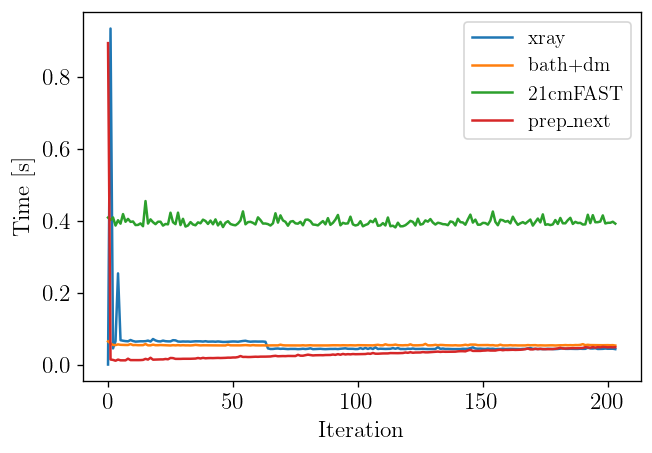

In [13]:
return_dict['profiler'].plot()

## compare

In [14]:
def plot_global(dh_soln, soln, tracker=False):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    color_dict = {
        'DH' : 'k',
        '21' : 'r',
    }

    z_plot_start = 50.
    i_z_st = np.argmin(np.abs(dh_soln['rs']-1 - z_plot_start))
    ax = axs[0,0]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['Tm'][i_z_st:]/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], ls=':', label='dm21cm')
    if tracker:
        ax.plot(soln['z'], soln['T_k_tracker'], color='b', ls='--', label='tracker')
    ax.plot(soln['z'][0], soln['T_k'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[0,1]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], ls=':', label='dm21cm')
    if tracker:
        ax.plot(soln['z'], soln['x_e_tracker'], color='b', ls='--', label='tracker')
    ax.plot(soln['z'][0], soln['x_e'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x_e$', title='$x_e$')
    ax.legend()

    ax = axs[0,2]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 0], color=color_dict['DH'], label='DH HII')
    #ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_soln['x'][i_z_st:, 1], color='b', label='DH HeII')
    ax.plot(soln['z'], soln['1-x_H'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['1-x_H'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$1-x_H$', title='$1-x_H$')
    ax.legend()

    ax = axs[0,3]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

    ax = axs[1,0]
    dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_bath_engs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['E_phot'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.plot(soln['z'][0], soln['E_phot'][0], color=color_dict['21'], marker='+', ms=5)
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$E$ [eV/Bavg]', title='Bath energy')

    ax = axs[1,1]
    dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{heat}$')

    ax = axs[1,2]
    dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_ion']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{ion}$')

    ax = axs[1,3]
    dh_fs = dh_soln['f']['low']['exc'] + dh_soln['f']['high']['exc']
    ax.plot(dh_soln['rs'][i_z_st:] - 1, dh_fs[i_z_st:], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['dep_exc']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$f$', title=r'$f\mathrm{exc}$')

/tmp/ipykernel_1065007/2960396429.py:57: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_heat']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
/tmp/ipykernel_1065007/2960396429.py:64: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_ion']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')
/tmp/ipykernel_1065007/2960396429.py:71: RuntimeWarning: invalid value encountered in divide
  ax.plot(soln['z'], soln['dep_exc']/soln['dE_inj_per_Bavg_unclustered'], color=color_dict['21'], ls=':', label='dm21cm')


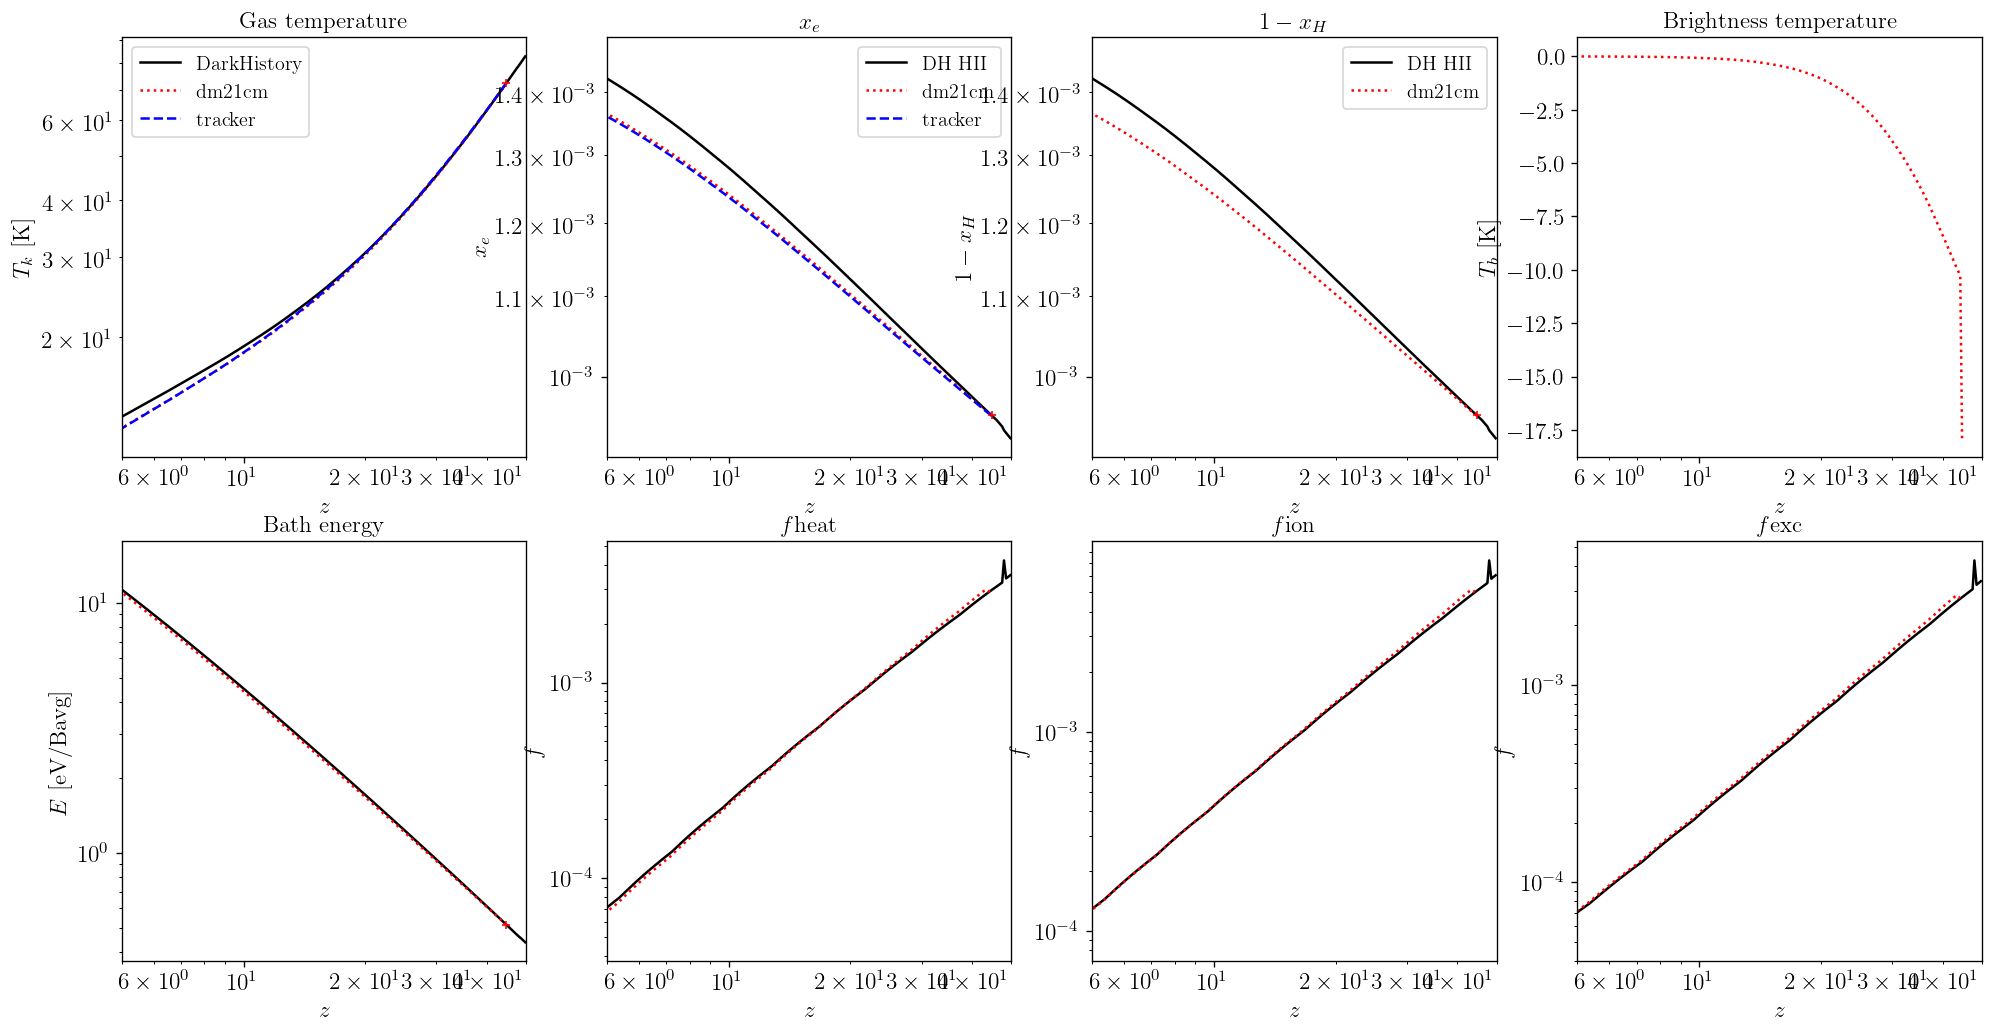

In [15]:
run_name = 'dhc_test'
dh_soln = pickle.load(open(f"run_info/{run_name}_dh_soln.p", 'rb'))
run_name = 'dhc_test'
soln = np.load(f"run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln, tracker=True)

In [23]:
soln['z'][5]

42.4614921890888

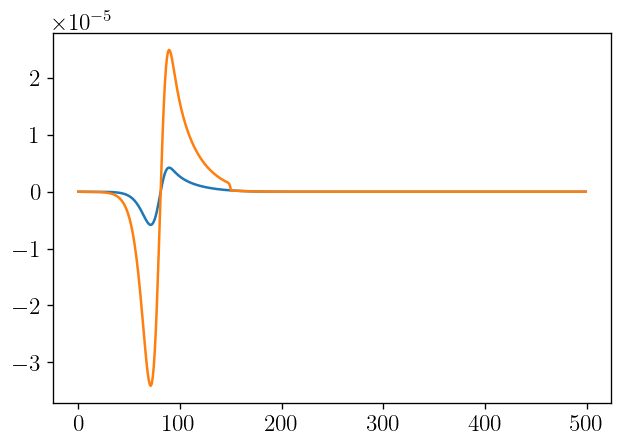

In [24]:
plt.plot(dh_bath_N_interp_func(soln['z'][5]))
plt.plot(soln['phot_N'][5])

In [31]:
from dm21cm.utils import load_h5_dict
abscs = load_h5_dict(f"../data/abscissas/abscs_zf01.h5")

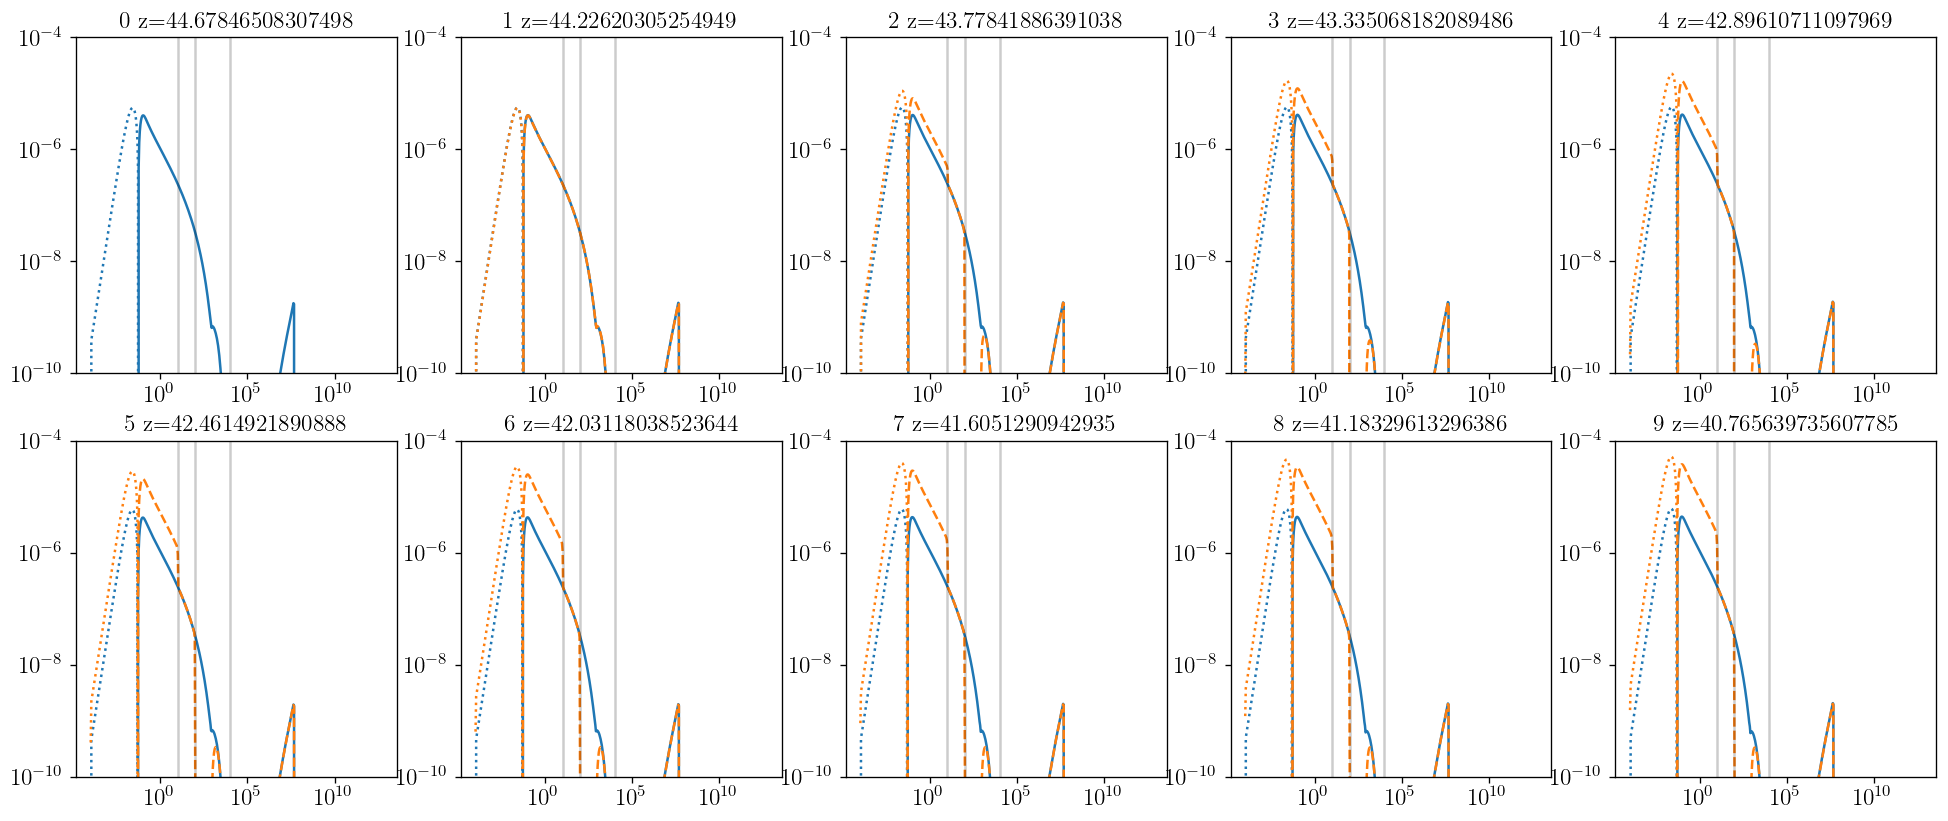

In [46]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.plot(abscs['photE'], dh_bath_N_interp_func(soln['z'][i]), color='C0')
    ax.plot(abscs['photE'], -dh_bath_N_interp_func(soln['z'][i]), color='C0', ls=':')
    ax.plot(abscs['photE'], soln['injected_bath_N'][i], color='C1', ls='--')
    ax.plot(abscs['photE'], -soln['injected_bath_N'][i], color='C1', ls=':')
    #ax.axvline(0.1, color='k', ls='-', alpha=0.2)
    ax.axvline(10.2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e2, color='k', ls='-', alpha=0.2)
    ax.axvline(1e4, color='k', ls='-', alpha=0.2)
    ax.set(xscale='log', yscale='log', ylim=(1e-10, 1e-4))
    ax.set(title=f"{i} z={soln['z'][i]}")

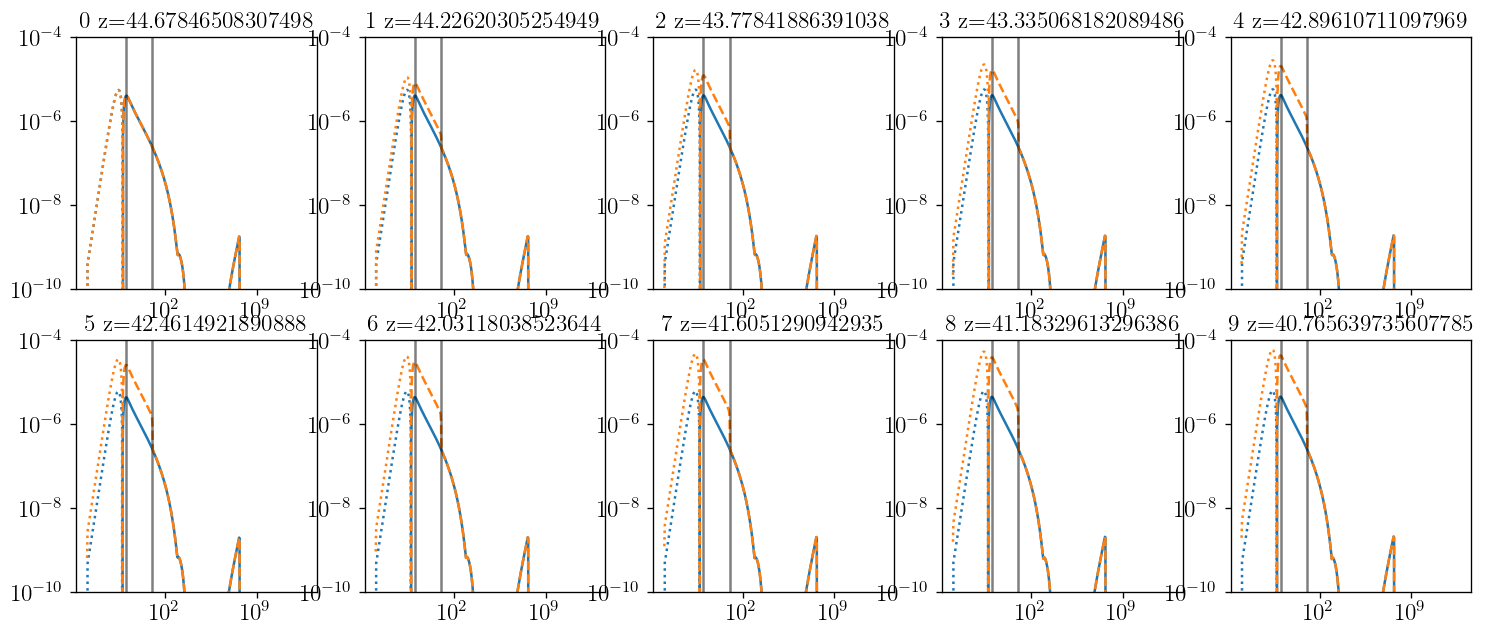

In [ ]:
# uniform xray flag is problematic
fig, axs = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    ax = axs[i//5, i%5]
    ax.plot(abscs['photE'], dh_bath_N_interp_func(soln['z'][i]), color='C0')
    ax.plot(abscs['photE'], -dh_bath_N_interp_func(soln['z'][i]), color='C0', ls=':')
    ax.plot(abscs['photE'], soln['phot_N'][i], color='C1', ls='--')
    ax.plot(abscs['photE'], -soln['phot_N'][i], color='C1', ls=':')
    ax.axvline(0.1, color='k', ls='-', alpha=0.5)
    ax.axvline(10, color='k', ls='-', alpha=0.5)
    ax.set(xscale='log', yscale='log', ylim=(1e-10, 1e-4))
    ax.set(title=f"{i} z={soln['z'][i]}")

In [118]:
phys.A_per_B

0.9999992500000001

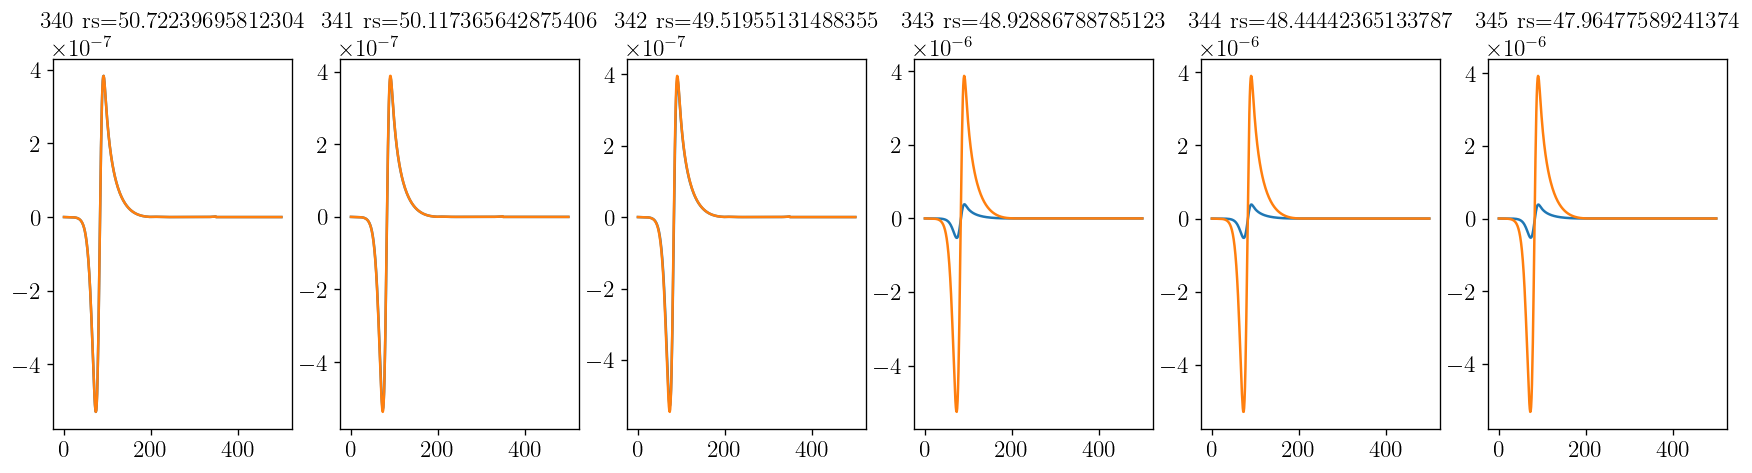

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18,4))
for i in range(6):
    axs[i].plot(dh_soln['highengphot'][340].N)
    axs[i].plot(dh_soln['highengphot'][340+i].N)
    axs[i].set(title=f"{340+i} rs={dh_soln['rs'][340+i]}")

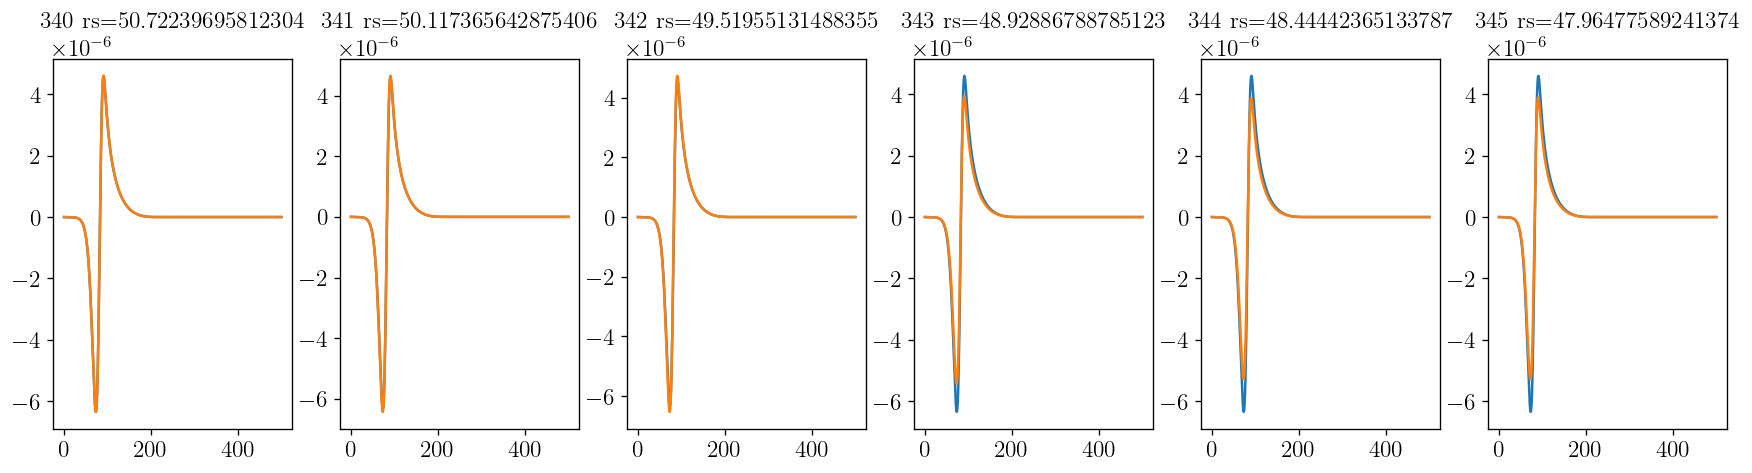

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(18,4))
for i in range(6):
    axs[i].plot(dh_soln['lowengphot'][340].N)
    axs[i].plot(dh_soln['lowengphot'][340+i].N)
    axs[i].set(title=f"{340+i} rs={dh_soln['rs'][340+i]}")

(45, 55)

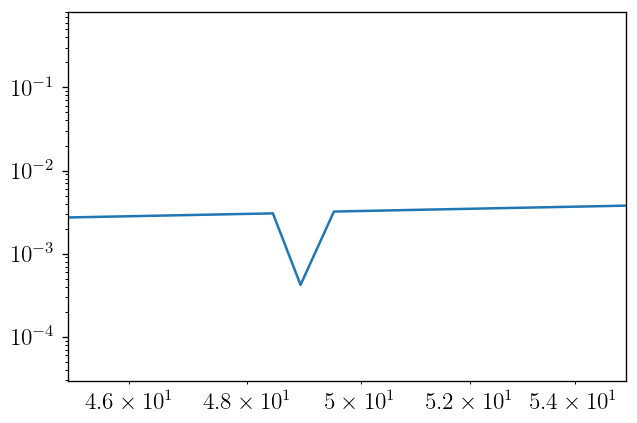

In [32]:
plt.plot(dh_soln['rs'], dh_soln['f']['low']['heat'])
plt.loglog()
plt.xlim(45, 55)

In [33]:
np.searchsorted(dh_soln['rs'][::-1], 45)

221

In [43]:
dh_soln['rs'][340:350]

array([50.72239696, 50.11736564, 49.51955131, 48.92886789, 48.44442365,
       47.96477589, 47.48987712, 47.01968032, 46.55413893, 46.09320686])

In [42]:
dh_soln['f']['low']['heat'][340:350]

array([0.00333702, 0.00327358, 0.00321077, 0.00042159, 0.0030538 ,
       0.00300836, 0.00296357, 0.00291929, 0.00287522, 0.00283162])

In [34]:
len(dh_soln['rs'])

573

In [23]:
from dm21cm.utils import load_h5_dict
abscs = load_h5_dict(f"../data/abscissas/abscs_{tf_version}.h5")

In [21]:
soln.keys()

dict_keys(['z', 'T_s', 'T_b', 'T_k', 'x_e', '1-x_H', 'E_phot', 'dE_inj_per_B', 'dE_inj_per_Bavg_unclustered', 'dep_ion', 'dep_exc', 'dep_heat', 'x_e_slice', 'x_H_slice'])

/tmp/ipykernel_1838978/3364818938.py:8: RuntimeWarning: invalid value encountered in divide
  interp_dm21 = interpolate.interp1d(soln['z'], soln[f'dep_{k}'] / soln[f'dE_inj_per_Bavg_unclustered'], bounds_error=False, fill_value=0.)


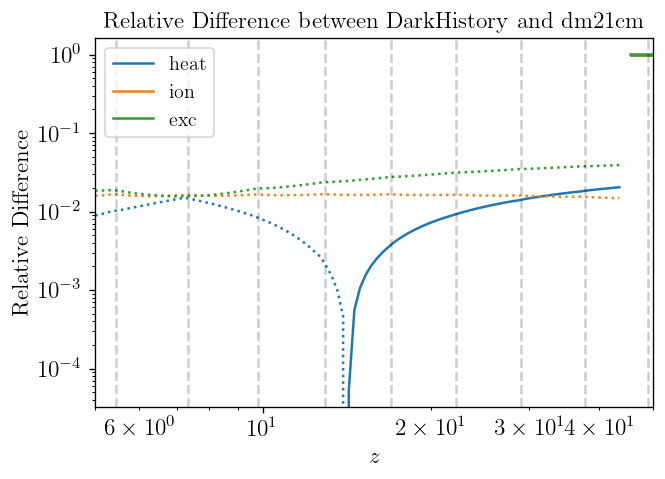

In [116]:
diffs = {}
for k in ['heat', 'ion', 'exc']:
    if k == 'ion':
        dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    else:
        dh_fs = dh_soln['f']['low'][k] + dh_soln['f']['high'][k]
    interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, dh_fs, bounds_error=False, fill_value=0.)
    interp_dm21 = interpolate.interp1d(soln['z'], soln[f'dep_{k}'] / soln[f'dE_inj_per_Bavg_unclustered'], bounds_error=False, fill_value=0.)

    common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
    common_dh = interp_dh(common_x)
    common_dm21 = interp_dm21(common_x)
    diffs.update({k : (common_dh - common_dm21) / common_dh})

fig, ax = plt.subplots()
for i, k in enumerate(diffs):
    ax.plot(common_x, diffs[k], label=k, color=f'C{i}')
    ax.plot(common_x, -diffs[k], ls=':', color=f'C{i}')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

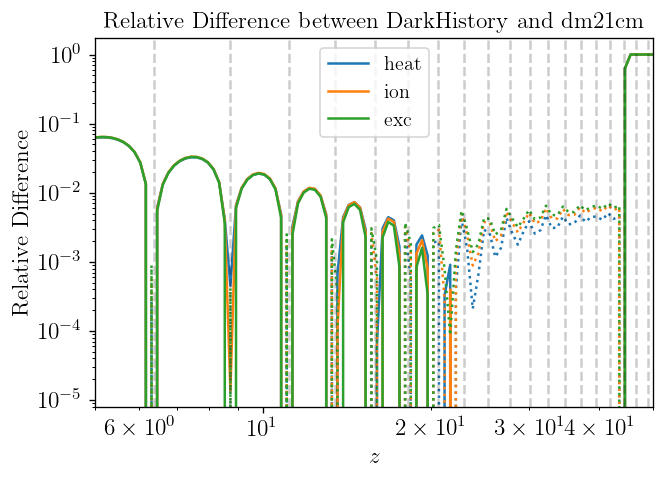

In [ ]:
diffs = {}
for k in ['heat', 'ion', 'exc']:
    if k == 'ion':
        dh_fs = dh_soln['f']['low']['H ion'] + dh_soln['f']['high']['H ion'] + dh_soln['f']['low']['He ion'] + dh_soln['f']['high']['He ion']
    else:
        dh_fs = dh_soln['f']['low'][k] + dh_soln['f']['high'][k]
    interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, dh_fs, bounds_error=False, fill_value=0.)
    interp_dm21 = interpolate.interp1d(soln['z'], soln[f'f_{k}'], bounds_error=False, fill_value=0.)

    common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
    common_dh = interp_dh(common_x)
    common_dm21 = interp_dm21(common_x)
    diffs.update({k : (common_dh - common_dm21) / common_dh})

fig, ax = plt.subplots()
for i, k in enumerate(diffs):
    ax.plot(common_x, diffs[k], label=k, color=f'C{i}')
    ax.plot(common_x, -diffs[k], ls=':', color=f'C{i}')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

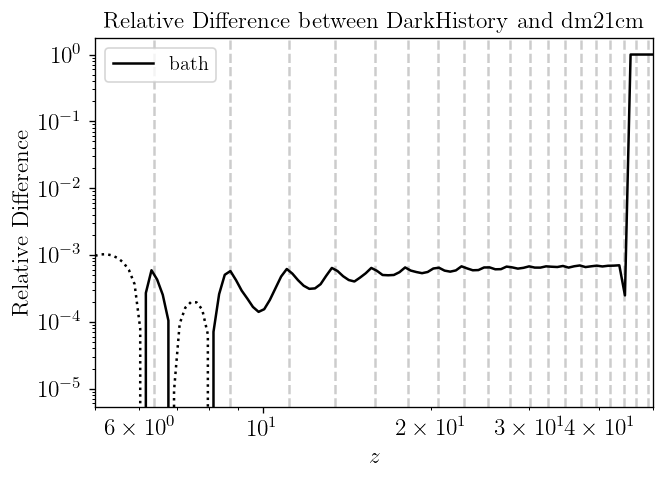

In [13]:
interp_dh = interpolate.interp1d(dh_soln['rs'] - 1, [s.toteng() for s in dh_soln['highengphot']], bounds_error=False, fill_value=0.)
interp_dm21 = interpolate.interp1d(soln['z'], soln['E_phot'], bounds_error=False, fill_value=0.)

common_x = np.geomspace(5, 50, 100)  # you can adjust the number of points
common_dh = interp_dh(common_x)
common_dm21 = interp_dm21(common_x)
diff = (common_dh - common_dm21) / common_dh

fig, ax = plt.subplots()
ax.plot(common_x, diff, label='bath', color=f'k')
ax.plot(common_x, -diff, ls=':', color=f'k')
for rs in abscs['rs']:
    ax.axvline(rs-1, ls='--', color='k', alpha=0.2)
ax.set(xlim=(5, 50), xscale='log', yscale='log')  # adjust scales as needed
ax.set(xlabel='$z$', ylabel='Relative Difference', title='Relative Difference between DarkHistory and dm21cm')
ax.legend()

In [18]:
dh_soln.keys()

dict_keys(['rs', 'x', 'Tm', 'highengphot', 'lowengphot', 'lowengelec', 'f'])

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_fs = dh_soln['f']['low']['heat'] + dh_soln['f']['high']['heat']
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_fs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['f_heat'][::-1])
(np.abs(p21c_arr-dh_arr)/dh_arr)

In [ ]:
zs = np.linspace(5.001, 44.999, 100)
dh_bath_engs = [s.toteng() for s in dh_soln['highengphot']]
dh_arr = np.interp(1+zs, dh_soln['rs'][::-1], dh_bath_engs[::-1])
p21c_arr = np.interp(zs, soln['z'][::-1], soln['E_phot'][::-1])
np.max(np.abs(p21c_arr-dh_arr)/dh_arr)

0.05427165381579362

In [ ]:
plt.plot(zs, p21c_arr)
plt.plot(zs, dh_arr)